In [1]:
### **Part 0: Preprocessing** - Import dependencies, define aliases, clean data, normalize clinic names, and create utility functions

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# import spacy

# # Load SpaCy model
# nlp = spacy.load('en_core_web_sm')

In [2]:
# aliases for filenames  
DATA_FILENAME = 'data.csv'
CLINICS_IN_RED_FILENAME = 'clinics.json'
TIER_COMPARISON_FILENAME = 'tier_comparison.json'

# aliases for relevant columns
ALIASES = {
    'CONCATENADO': 'ID',
    'Clinica1': 'CLINIC',
    'fe_declaracion': 'DATE',
    'procedimiento': 'PROCEDURE',
    'estatus_siniestro1': 'STATUS',
    'pais': 'COUNTRY',
    'Region': 'REGION',
    'tipo_siniestro1': 'TYPE',
    'monto usd': 'PAID_USD',
    'SA': 'INSURANCE_COVERAGE',
    'enfermedad1': 'CONDITION',
    'tipo_proc': 'PROCEDURE_TYPE',
    'Rango edad': 'AGE_RANGE'
}

# type definitions for relevant columns
DATA_TYPE_DICT = {
    'CONCATENADO': 'object',
    'Clinica1': 'object',
    'fe_declaracion': 'object',
    'procedimiento': 'object',
    'estatus_siniestro1': 'object',
    'pais': 'object',
    'Region': 'object',
    'tipo_siniestro1': 'object',
    'monto usd': 'object',  # Changed from float64 to object
    'SA': 'object',         # Changed from float64 to object
    'enfermedad1': 'object',
    'tipo_proc': 'object',
    'Rango edad': 'object'
}

# format floats
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.copy_on_write = True

In [3]:
# read utils 
def df_data(filename): 
    """
    Reads .csv file and returns DataFrame with relevant columns.
    Now includes data cleaning for numeric columns.
    """
    # First, read the CSV without dtype specifications to see actual columns
    df = pd.read_csv(filename, encoding='utf-8', low_memory=False)
    
    # Print actual columns to help debug
    print("Available columns in CSV:", df.columns.tolist())
    
    # Create a mapping of available columns to their dtypes
    available_dtypes = {col: DATA_TYPE_DICT[col] for col in DATA_TYPE_DICT if col in df.columns}
    
    # Read again with correct dtypes
    df = pd.read_csv(filename, dtype=available_dtypes, encoding='utf-8', low_memory=False)
    
    # Select only the columns that exist
    existing_columns = [col for col in DATA_TYPE_DICT if col in df.columns]
    if not existing_columns:
        raise ValueError("None of the specified columns found in the CSV file!")
    
    df = df[existing_columns]
    
    # Clean numeric columns
    # Replace '-' with NaN and convert to float
    if 'monto usd' in df.columns:
        df['monto usd'] = pd.to_numeric(df['monto usd'].replace('-', np.nan), errors='coerce')
    if 'SA' in df.columns:
        df['SA'] = pd.to_numeric(df['SA'].replace('-', np.nan), errors='coerce')
    
    return df

def json_data(filename): 
    """
    Reads filename and returns json object. 
    """      
    with open(filename) as file:
        return json.load(file)
# transform utils

def normalized(df, column, reference, threshold=90):
    """
    Normalizes a column given a reference name using closest matches. 
    Fixes inconsistent entries that refer to the same value.
    Matches only apply if the confidence score is above the given threshold.
    Displays the number of unique clinic names before and after normalization.
    Prints which names were normalized.
    """
    
    # Count unique values before normalization
    unique_before = df[column].nunique()

    # Create the mapping with confidence filtering
    mapping = {}
    normalized_log = []  # Track normalized entries
    for clinic in df[column].unique():
        match = process.extractOne(clinic, reference)
        if match and match[1] >= threshold:  # Check confidence score
            normalized_name = match[0]
            if clinic != normalized_name:
                normalized_log.append((clinic, normalized_name))  # Log changes
            mapping[clinic] = normalized_name
        else:
            mapping[clinic] = clinic  # Retain original name if confidence is low

    # Normalize the column
    df[column] = df[column].map(mapping)

    # Count unique values after normalization
    unique_after = df[column].nunique()

    # Print unique counts
    print(f"Unique clinic names before normalization: {unique_before}")
    print(f"Unique clinic names after normalization: {unique_after}")

    # Print what names were normalized
    if normalized_log:
        print("\nNormalized Names:")
        for original, normalized in normalized_log:
            print(f"  {original} -> {normalized}")
    else:
        print("\nNo names were normalized.")

    return df

In [4]:
# read json files as dictionaries
CLINICS_IN_RED = json_data(CLINICS_IN_RED_FILENAME) # clinic to joined_dates and tier
TIER_COMPARSION = json_data(TIER_COMPARISON_FILENAME) # comparison clinics for each tier

def in_red(entry): 
    """
    Determines if an entry was handled in red. 
    True if: 
        1. Clinic is in red for entry's type and 
        2. Entry happened on or after the clinic joined the red for entry's type
    False otherwise.    
    """ 
    clinic = entry['CLINIC']
    type = entry['TYPE']
    date = entry['DATE']
    if clinic not in CLINICS_IN_RED or type not in CLINICS_IN_RED[clinic]['join_date']:
        return False
    join_date = datetime.strptime(
        CLINICS_IN_RED[clinic]['join_date'][type], '%m/%d/%Y')
    if date < join_date:
        return False
    return True

# read
df = df_data(DATA_FILENAME)

# rename
df.rename(columns=ALIASES, inplace=True)

# filter
df_filtered = df[
    (df["STATUS"] == "CERRADO") & 
    (df["REGION"] == "Caracas") & 
    (df["TYPE"].isin(["EMERGENCIA", "CARTA AVAL"]))
]

# transform dates to datetime objects
df_filtered['DATE'] = pd.to_datetime(
        df_filtered['DATE'], format='%m/%d/%Y')

# normalize
standard_clinic_names = set(CLINICS_IN_RED.keys()) | set(
    c for t in TIER_COMPARSION.keys() for c in TIER_COMPARSION[t]
)
df_normalized = normalized(df_filtered, "CLINIC", standard_clinic_names)

# aggregate by ID, CLINIC, and TYPE
df_aggregated = df_normalized.groupby(["ID", "CLINIC", "TYPE"]).agg({
    'DATE': 'min',  # Earliest and latest dates
    'PROCEDURE': list,       # List of procedures
    'PAID_USD': 'sum',       # Sum of payments
}).reset_index()

# flatten multi-level column names
df_aggregated.columns = ['ID', 'CLINIC', 'TYPE', 'DATE', 'PROCEDURES', 'PAID_USD']

# classify
df_aggregated["IN_RED"] = df_aggregated.apply(in_red, axis=1)

# save to CSV
df_aggregated.to_csv('data_clean.csv', index=False)

# display the result
df_aggregated.head()

Available columns in CSV: ['sucursal', 'ramo', 'poliza', 'de_motivo_siniestro', 'causa_siniestro', 'cd_pais', 'cd_usuario', 'siniestro', 'tipo_siniestro', 'estatus_siniestro', 'facturado', 'monto_usd', 'fe_ocurrencia', 'fe_declaracion', 'enfermedad', 'procedimiento', 'especialidad', 'tratamiento', 'nombre_afectado', 'cedula_afectado', 'edad', 'concepto', 'rif_contratante', 'contratante', 'cd_mediador', 'nm_mediador', 'estado', 'rif_clin', 'clinica', 'tipo_proveedor', 'fe_ingreso', 'fe_egreso', 'pais', 'ciudad', 'conexion', 'localidad', 'monto usd', 'tipo_siniestro1', 'CONCATENADO', 'Mes', 'Año', 'Region', 'Ocurrencia', 'estatus_siniestro1', 'tipo de poliza', 'tipo_proc', 'Rango edad', 'Proveedor Internacional', 'Categoría', 'SA', 'Producto', 'Clinica1', 'enfermedad1', 'tasa ocurrencia', 'Facturado_usd', 'desglose1']
Unique clinic names before normalization: 231
Unique clinic names after normalization: 228

Normalized Names:
  POLICLINICA LA ARBOLEDA, C.A -> POLICLINICA LA ARBOLEDA, C.A

,ID,CLINIC,TYPE,DATE,PROCEDURES,PAID_USD,IN_RED
0,"00673554EMBARAZO, PARTO Y PUERPERIOoctubre2023...","HOSPITAL DE CLINICAS CARACAS, C.A.",EMERGENCIA,2023-10-30,[TRATAMIENTO MEDICO CON PROCEDIMIENTO NO BAREM...,5684.000,False
1,00673554NAUSEA Y VOMITOabril2023EMERGENCIA,"HOSPITAL DE CLINICAS CARACAS, C.A.",EMERGENCIA,2023-04-09,"[TRATAMIENTO MEDICO AMBULATORIO, TRATAMIENTO M...",633.000,False
2,069701191TRAUMATISMO SUPERFICIAL DE LA CADERA ...,A.C. CENTRO MEDICO DOCENTE LA TRINIDAD,EMERGENCIA,2023-07-26,[ Esguince Tobillo],1873.000,False
3,091139498FRACTURAS QUE AFECTAN MULTIPLES REGIO...,INTERVERTEBRA C.A.,EMERGENCIA,2023-05-13,[TRATAMIENTO MEDICO CON HOSPITALIZACION],7095.000,False
4,099809108TRAUMATISMO SUPERFICIAL DE LA CADERA ...,"GRUPO MEDICO SANTA PAULA, S.A. (GMSP S.A.)",EMERGENCIA,2024-03-05,"[ Esguince Tobillo, Esguince Tobillo]",805.000,False


In [5]:
def cluster_procedures(procedures):
    """Groups similar procedures using NLP"""
    
    # Preprocess procedures - convert all items to strings and filter out non-string values
    proc_texts = []
    for proc_list in procedures:
        # Convert all items to strings and filter out None/NaN
        clean_procs = [str(p) for p in proc_list if p is not None and pd.notna(p)]
        if clean_procs:  # Only join if there are valid procedures
            proc_texts.append(' '.join(clean_procs))
        else:
            proc_texts.append('')  # Empty string for invalid procedures
    
    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        max_features=1000  # Limit features to most important ones
    )
    
    # Handle empty case
    if not proc_texts or all(text == '' for text in proc_texts):
        return {}
    
    vectors = vectorizer.fit_transform(proc_texts)
    
    # Cluster procedures
    n_clusters = min(len(proc_texts) // 10, 50)  # Reasonable number of clusters
    n_clusters = max(n_clusters, 1)  # Ensure at least 1 cluster
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    # Create mapping of procedures to clusters
    proc_clusters = {}
    for proc, cluster in zip(procedures, clusters):
        proc_key = tuple(str(p) for p in proc if p is not None and pd.notna(p))  # Make procedure list hashable
        if proc_key:  # Only add if there are valid procedures
            proc_clusters[proc_key] = cluster
            
    return proc_clusters

### **Part 1: Descriptive Analysis**

#### Part 1.1: Overview

In [6]:
### Part 1: Descriptive Analysis

# Basic dataset statistics
print(f"Total number of claims: {len(df_aggregated):,}")
print(f"Date range: {df_aggregated['DATE'].min().strftime('%m/%d/%Y')} to {df_aggregated['DATE'].max().strftime('%m/%d/%Y')}")
print(f"Number of unique clinics: {df_aggregated['CLINIC'].nunique():,}")
print(f"Number of unique procedures: {df_normalized['PROCEDURE'].nunique():,}")
print(f"\nTotal amount paid (USD): ${df_aggregated['PAID_USD'].sum():,.2f}")
print(f"Average claim amount (USD): ${df_aggregated['PAID_USD'].mean():,.2f}")
print(f"Median claim amount (USD): ${df_aggregated['PAID_USD'].median():,.2f}")


top_clinics = df_aggregated['CLINIC'].value_counts().head(10)
print("Top 10 Clinics by Number of Claims:")
for clinic, count in top_clinics.items():
    total_amount = df_aggregated[df_aggregated['CLINIC'] == clinic]['PAID_USD'].sum()
    avg_amount = df_aggregated[df_aggregated['CLINIC'] == clinic]['PAID_USD'].mean()
    print(f"\n{clinic}")
    print(f"  Claims: {count:,}")
    print(f"  Total Amount: ${total_amount:,.2f}")
    print(f"  Average Amount: ${avg_amount:,.2f}")


Total number of claims: 47,427
Date range: 01/01/2023 to 05/30/2024
Number of unique clinics: 228
Number of unique procedures: 459

Total amount paid (USD): $135,670,167.00
Average claim amount (USD): $2,860.61
Median claim amount (USD): $1,370.00
Top 10 Clinics by Number of Claims:

A.C. CENTRO MEDICO DOCENTE LA TRINIDAD
  Claims: 5,228
  Total Amount: $19,584,993.00
  Average Amount: $3,746.17

POLICLINICA METROPOLITANA, C.A.
  Claims: 3,945
  Total Amount: $15,311,877.00
  Average Amount: $3,881.34

CLINICA SANTIAGO DE LEON, C.A.
  Claims: 3,087
  Total Amount: $7,261,662.00
  Average Amount: $2,352.34

CLINICA EL AVILA, C.A.
  Claims: 3,043
  Total Amount: $7,722,080.00
  Average Amount: $2,537.65

GRUPO MEDICO SANTA PAULA, S.A. (GMSP S.A.)
  Claims: 2,588
  Total Amount: $8,760,369.00
  Average Amount: $3,385.00

VENEURGENCIAS C.A
  Claims: 2,452
  Total Amount: $768,860.00
  Average Amount: $313.56

CENTRO CLINICO FENIX SALUD,C.A.
  Claims: 1,693
  Total Amount: $4,264,339.00
  A

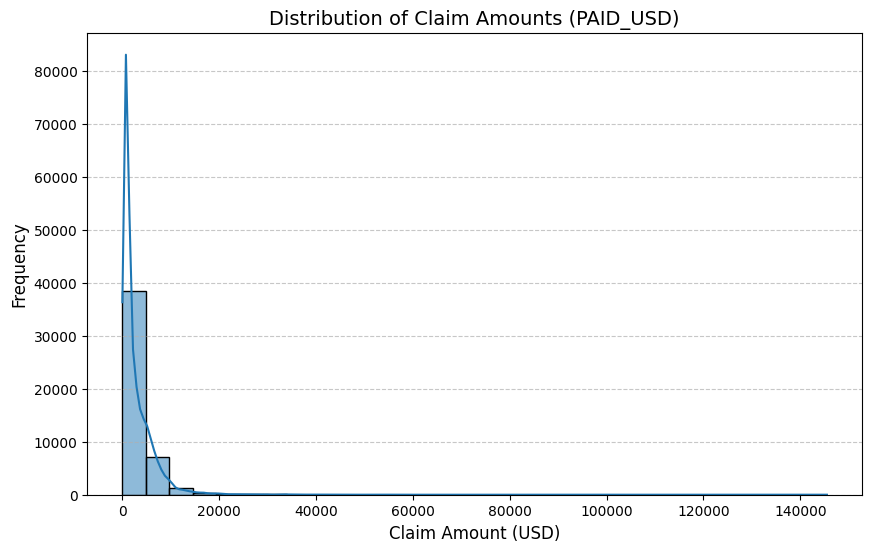

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/4061169245.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_clinics.values, y=top_clinics.index, palette="viridis")


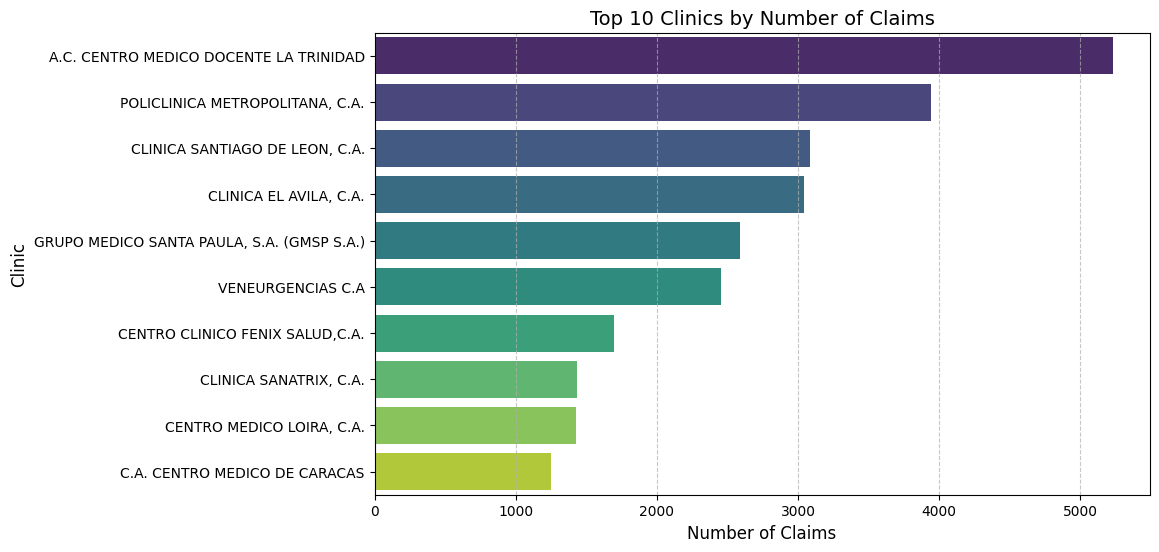

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/4061169245.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_paid.values, y=total_paid.index, palette="coolwarm")


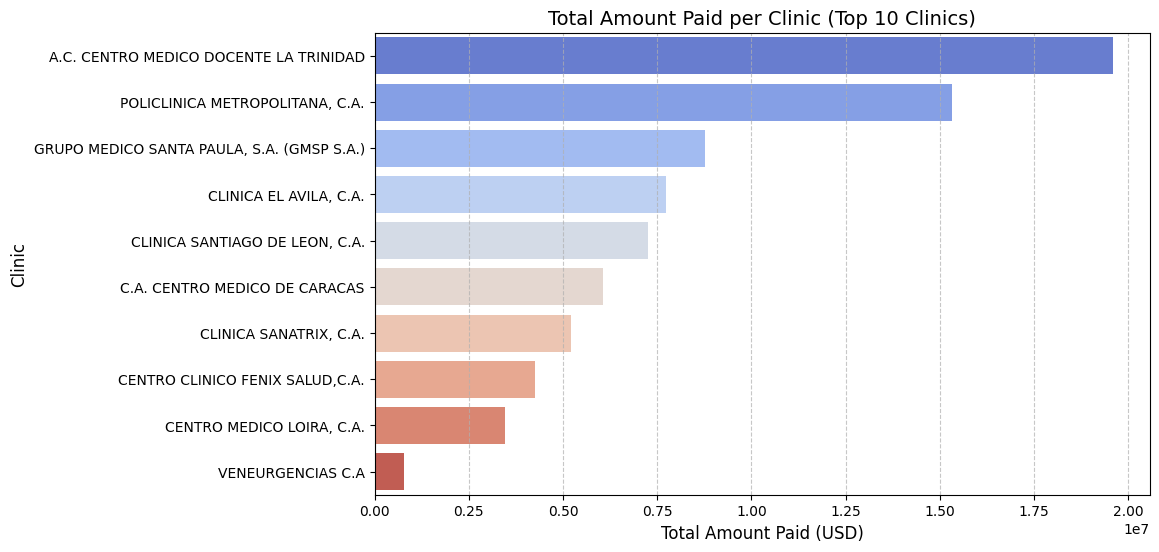

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/4061169245.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_paid.values, y=average_paid.index, palette="magma")


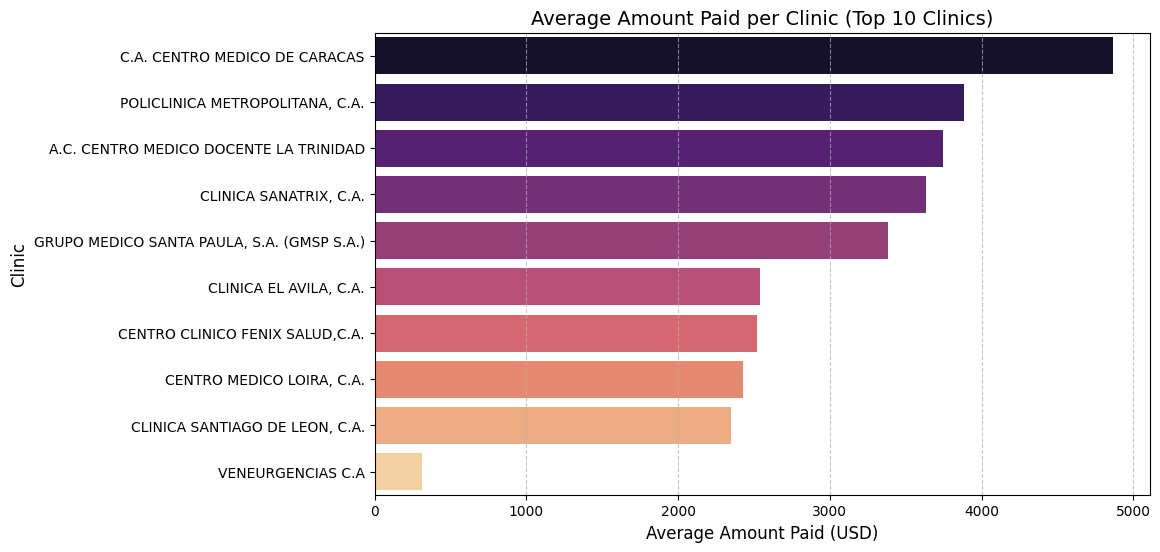

In [7]:
# Distribution of Claim Amounts
plt.figure(figsize=(10, 6))
sns.histplot(df_aggregated['PAID_USD'], bins=30, kde=True)
plt.title('Distribution of Claim Amounts (PAID_USD)', fontsize=14)
plt.xlabel('Claim Amount (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Number of Claims per Clinic (Top 10 Clinics)
plt.figure(figsize=(10, 6))
top_clinics = df_aggregated['CLINIC'].value_counts().head(10)
sns.barplot(x=top_clinics.values, y=top_clinics.index, palette="viridis")
plt.title('Top 10 Clinics by Number of Claims', fontsize=14)
plt.xlabel('Number of Claims', fontsize=12)
plt.ylabel('Clinic', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Total Amount Paid per Clinic (Top 10 Clinics)
plt.figure(figsize=(10, 6))
total_paid = df_aggregated[df_aggregated['CLINIC'].isin(top_clinics.index)].groupby('CLINIC')['PAID_USD'].sum().sort_values(ascending=False)
sns.barplot(x=total_paid.values, y=total_paid.index, palette="coolwarm")
plt.title('Total Amount Paid per Clinic (Top 10 Clinics)', fontsize=14)
plt.xlabel('Total Amount Paid (USD)', fontsize=12)
plt.ylabel('Clinic', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Average Amount Paid per Clinic (Top 10 Clinics)
plt.figure(figsize=(10, 6))
average_paid = df_aggregated[df_aggregated['CLINIC'].isin(top_clinics.index)].groupby('CLINIC')['PAID_USD'].mean().sort_values(ascending=False)
sns.barplot(x=average_paid.values, y=average_paid.index, palette="magma")
plt.title('Average Amount Paid per Clinic (Top 10 Clinics)', fontsize=14)
plt.xlabel('Average Amount Paid (USD)', fontsize=12)
plt.ylabel('Clinic', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# Top 10 procedures
top_procedures = df_normalized['PROCEDURE'].value_counts().head(13)
print("Top 13 Procedures (first 3 are too broad to categorize):")
for procedure, count in top_procedures.items():
    total_amount = df_normalized[df_normalized['PROCEDURE'] == procedure]['PAID_USD'].sum()
    avg_amount = df_normalized[df_normalized['PROCEDURE'] == procedure]['PAID_USD'].mean()
    print(f"\n{procedure}")
    print(f"  Claims: {count:,}")
    print(f"  Total Amount: ${total_amount:,.2f}")
    print(f"  Average Amount: ${avg_amount:,.2f}")


Top 13 Procedures (first 3 are too broad to categorize):

TRATAMIENTO MEDICO AMBULATORIO
  Claims: 35,606
  Total Amount: $21,998,432.00
  Average Amount: $617.83

TRATAMIENTO MEDICO CON HOSPITALIZACION
  Claims: 21,065
  Total Amount: $38,142,437.00
  Average Amount: $1,810.70

TRATAMIENTO MEDICO CON PROCEDIMIENTO NO BAREMIZADO
  Claims: 4,301
  Total Amount: $12,603,069.00
  Average Amount: $2,930.26

Cesárea
  Claims: 1,973
  Total Amount: $4,102,508.00
  Average Amount: $2,079.32

Facomulsificación + LIO
  Claims: 1,686
  Total Amount: $1,650,476.00
  Average Amount: $978.93

Facoemulsificación de Catarata con Implante de LIO Monofocal
  Claims: 1,016
  Total Amount: $1,058,181.00
  Average Amount: $1,041.52

Colecistectomia Laparoscopica
  Claims: 900
  Total Amount: $2,186,484.00
  Average Amount: $2,429.43

 Esguince Tobillo
  Claims: 586
  Total Amount: $349,600.00
  Average Amount: $596.59

Apendicectomía Laparoscópica
  Claims: 417
  Total Amount: $1,140,762.00
  Average Amou

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/994717141.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


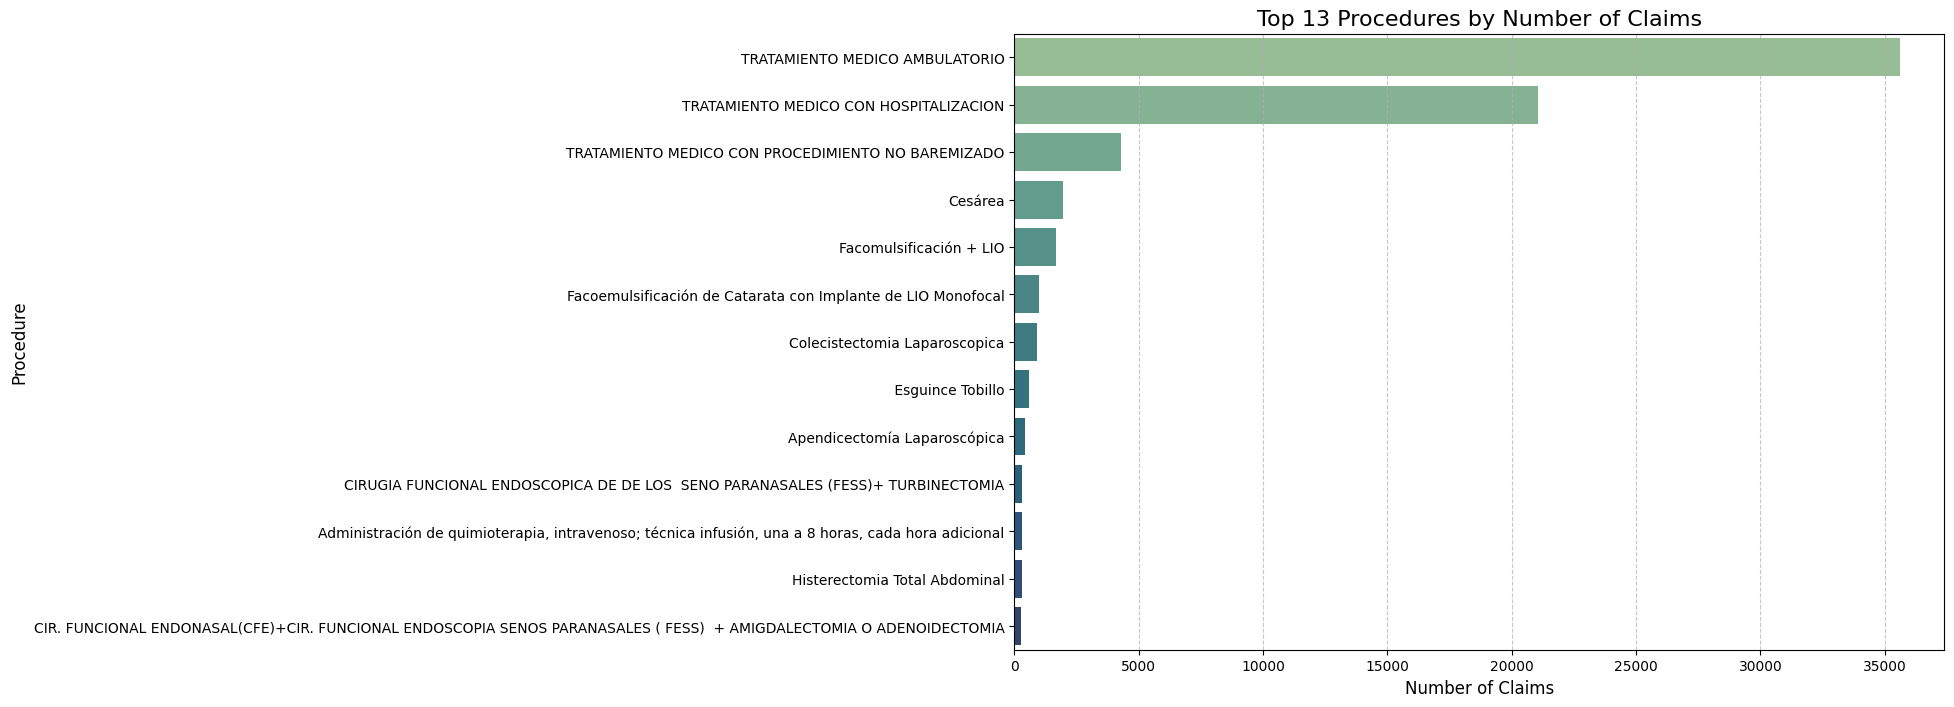

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/994717141.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


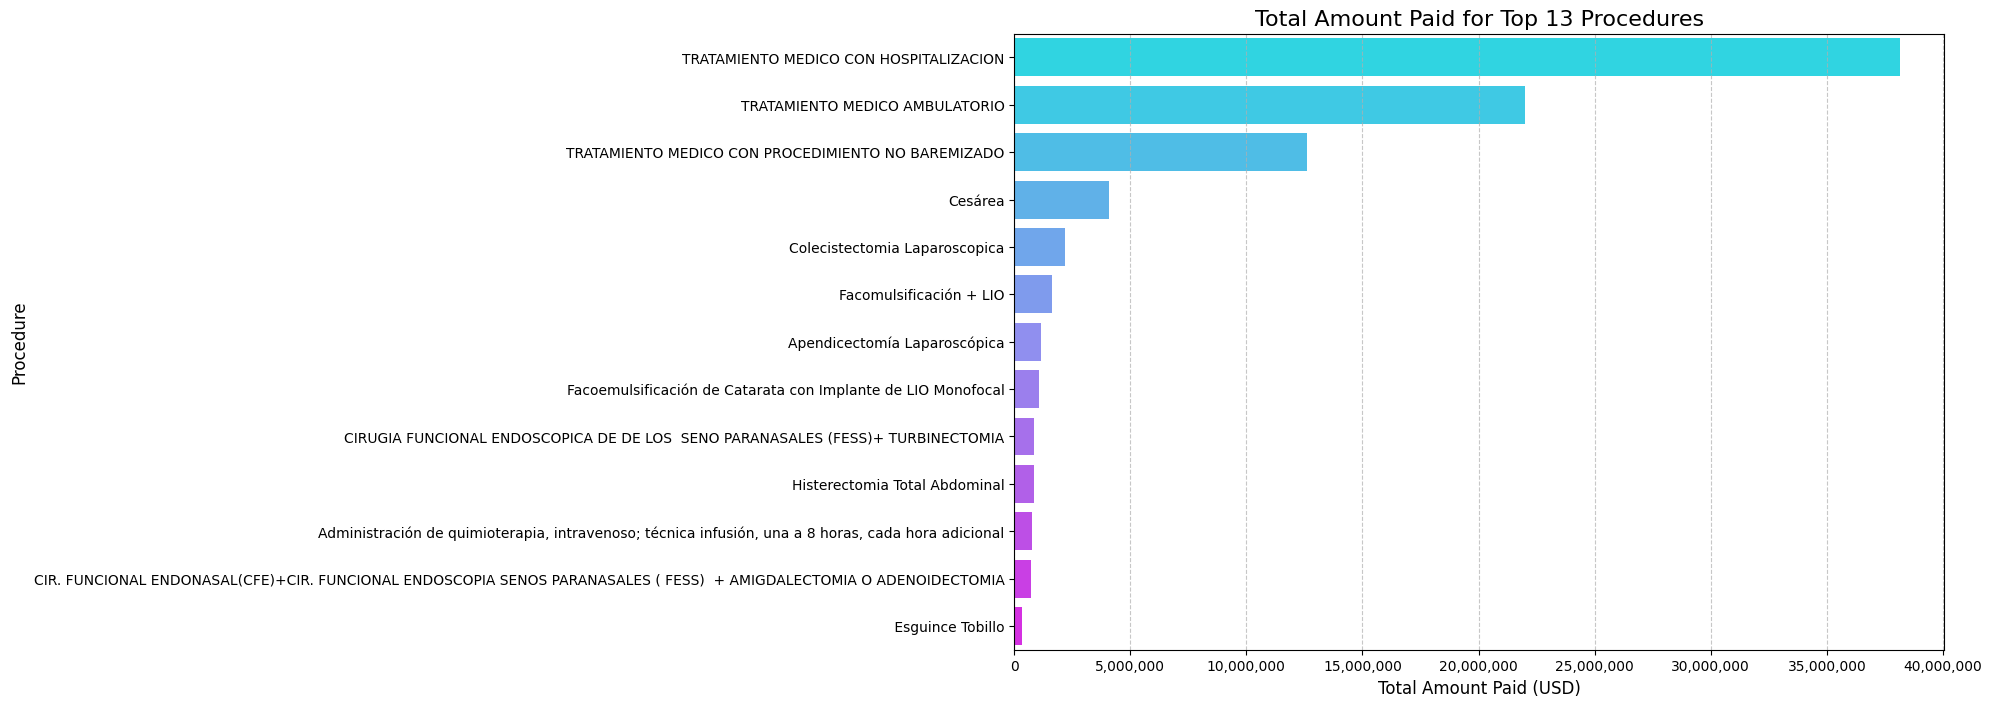

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/994717141.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


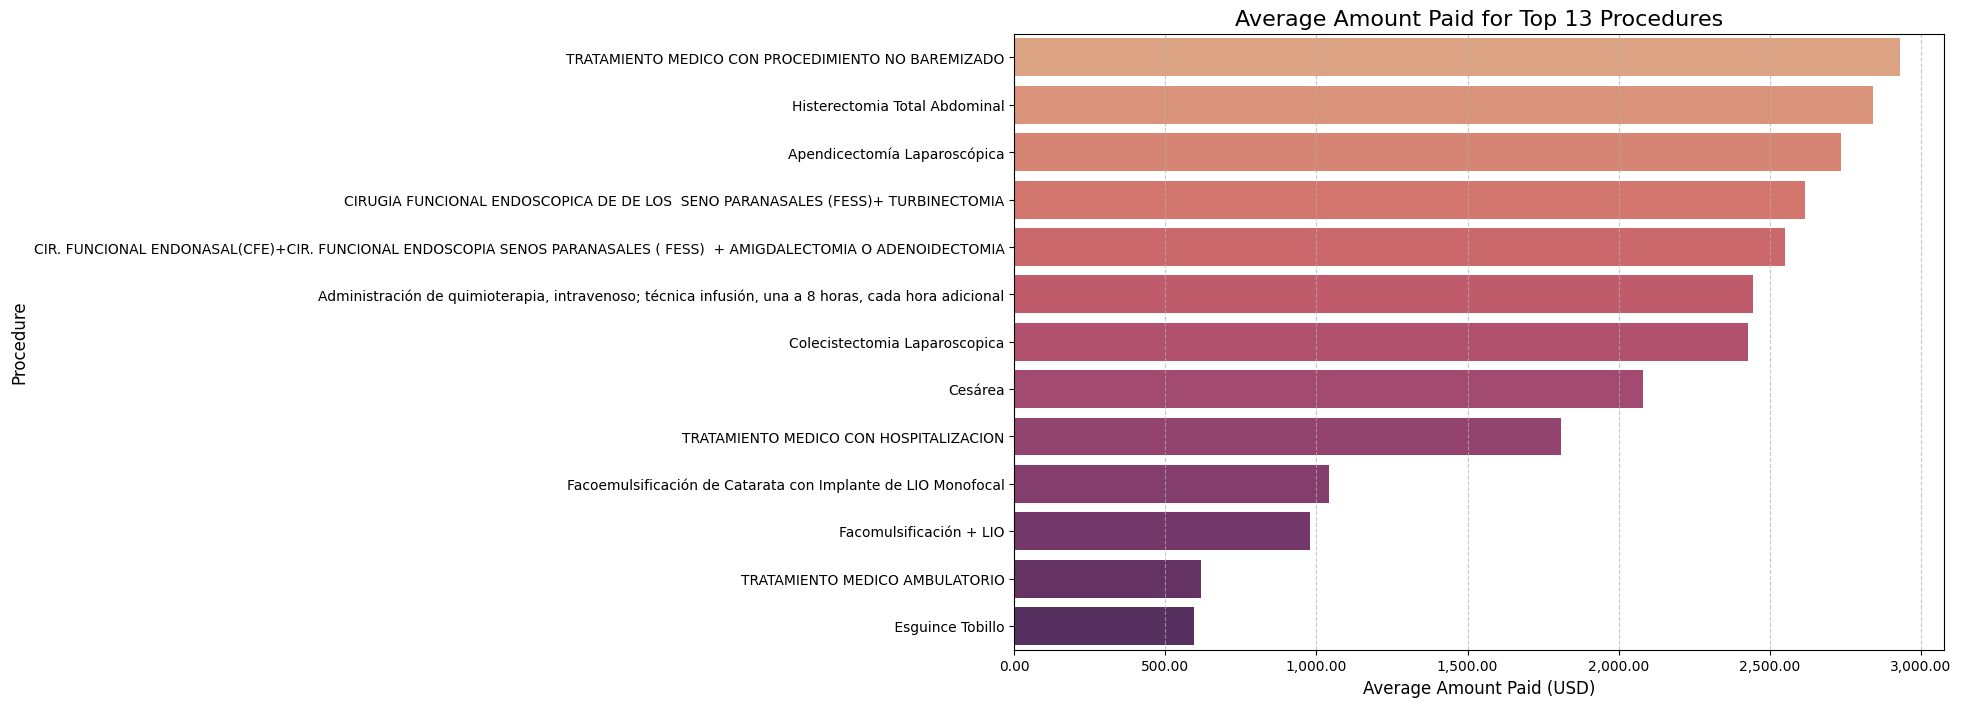

In [9]:
# Bar Chart for Top 13 Procedures by Number of Claims
plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_procedures.values,
    y=top_procedures.index,
    palette="crest"
)
plt.title('Top 13 Procedures by Number of Claims', fontsize=16)
plt.xlabel('Number of Claims', fontsize=12)
plt.ylabel('Procedure', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Bar Chart for Total Amount Paid for Top 13 Procedures
import matplotlib.ticker as mticker

plt.figure(figsize=(12, 8))
total_amount_procedures = df_normalized[df_normalized['PROCEDURE'].isin(top_procedures.index)] \
    .groupby('PROCEDURE')['PAID_USD'].sum().sort_values(ascending=False)
sns.barplot(
    x=total_amount_procedures.values,
    y=total_amount_procedures.index,
    palette="cool"
)
plt.title('Total Amount Paid for Top 13 Procedures', fontsize=16)
plt.xlabel('Total Amount Paid (USD)', fontsize=12)
plt.ylabel('Procedure', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

# Bar Chart for Average Amount Paid for Top 13 Procedures
plt.figure(figsize=(12, 8))
average_amount_procedures = df_normalized[df_normalized['PROCEDURE'].isin(top_procedures.index)] \
    .groupby('PROCEDURE')['PAID_USD'].mean().sort_values(ascending=False)
sns.barplot(
    x=average_amount_procedures.values,
    y=average_amount_procedures.index,
    palette="flare"
)
plt.title('Average Amount Paid for Top 13 Procedures', fontsize=16)
plt.xlabel('Average Amount Paid (USD)', fontsize=12)
plt.ylabel('Procedure', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
plt.show()

In [10]:
# Network statistics
df_aggregated['IN_RED'] = df_aggregated['IN_RED'].astype('category')  # Convert to category
in_red_stats = df_aggregated.groupby('IN_RED').agg({
    'ID': 'count',
    'PAID_USD': ['sum', 'mean', 'median']
}).round(2)

print("Network vs Non-Network Statistics:")
for network_status in [True, False]:
    status_label = "In-Network" if network_status else "Out-of-Network"
    subset = df_aggregated[df_aggregated['IN_RED'] == network_status]
    
    if len(subset) > 0:
        print(f"\n{status_label}:")
        print(f"  Number of Claims: {len(subset):,}")
        print(f"  Total Amount: ${subset['PAID_USD'].sum():,.2f}")
        print(f"  Average Amount: ${subset['PAID_USD'].mean():,.2f}")
        print(f"  Median Amount: ${subset['PAID_USD'].median():,.2f}")
    else:
        print(f"\n{status_label}: No claims found")

Network vs Non-Network Statistics:

In-Network:
  Number of Claims: 1,974
  Total Amount: $5,817,076.00
  Average Amount: $2,946.85
  Median Amount: $1,485.50

Out-of-Network:
  Number of Claims: 45,453
  Total Amount: $129,853,091.00
  Average Amount: $2,856.87
  Median Amount: $1,365.00


/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3712268490.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  in_red_stats = df_aggregated.groupby('IN_RED').agg({


/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3969811843.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  network_stats = df_aggregated.groupby('IN_RED')['PAID_USD'].sum().reset_index()
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3969811843.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


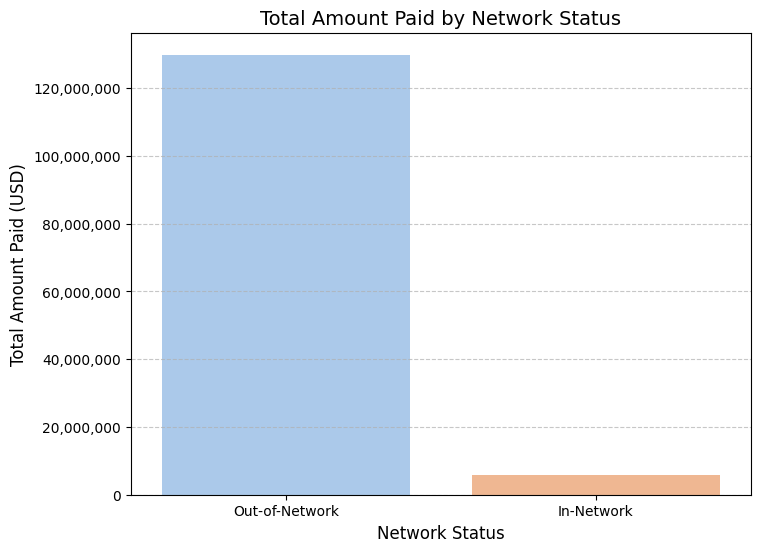

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3969811843.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_network_stats = df_aggregated.groupby('IN_RED')['PAID_USD'].mean().reset_index()
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3969811843.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


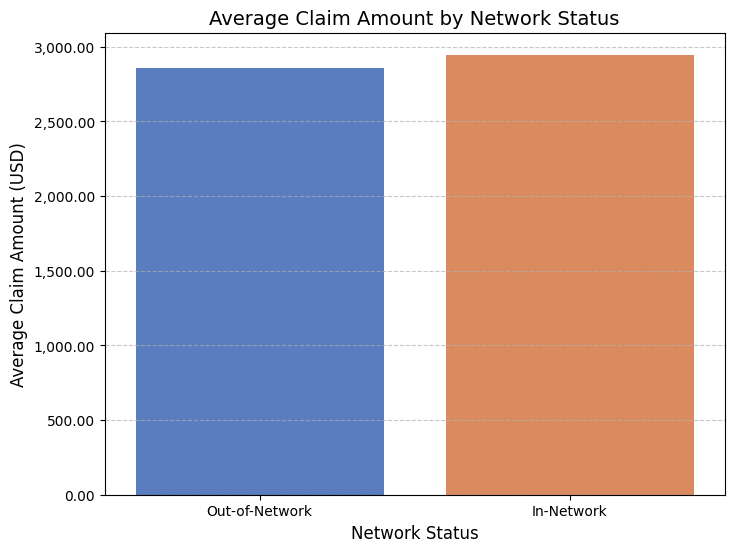

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3969811843.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


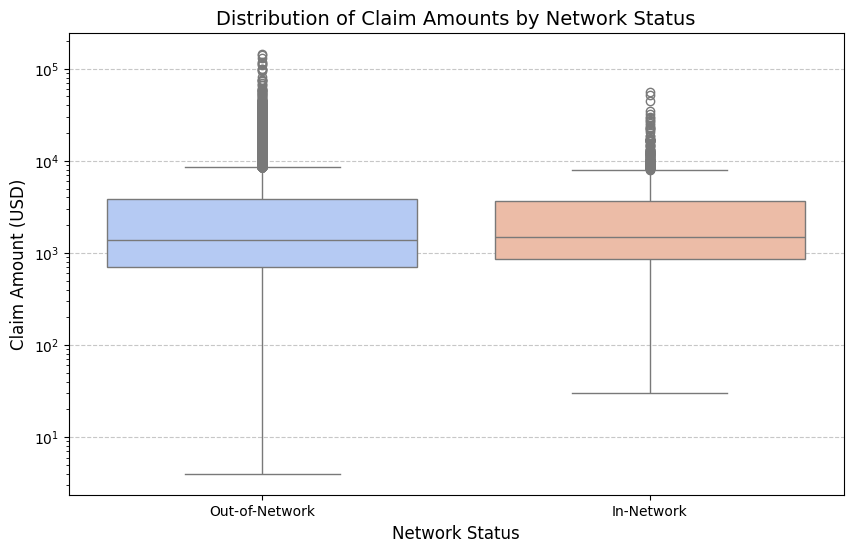

In [11]:
# Bar Chart for Total Amount Paid by Network Status
plt.figure(figsize=(8, 6))
network_stats = df_aggregated.groupby('IN_RED')['PAID_USD'].sum().reset_index()
network_stats['IN_RED'] = network_stats['IN_RED'].map({True: 'In-Network', False: 'Out-of-Network'})
sns.barplot(
    x='IN_RED',
    y='PAID_USD',
    data=network_stats,
    palette='pastel'
)
plt.title('Total Amount Paid by Network Status', fontsize=14)
plt.xlabel('Network Status', fontsize=12)
plt.ylabel('Total Amount Paid (USD)', fontsize=12)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar Chart for Average Claim Amount by Network Status
plt.figure(figsize=(8, 6))
avg_network_stats = df_aggregated.groupby('IN_RED')['PAID_USD'].mean().reset_index()
avg_network_stats['IN_RED'] = avg_network_stats['IN_RED'].map({True: 'In-Network', False: 'Out-of-Network'})
sns.barplot(
    x='IN_RED',
    y='PAID_USD',
    data=avg_network_stats,
    palette='muted'
)
plt.title('Average Claim Amount by Network Status', fontsize=14)
plt.xlabel('Network Status', fontsize=12)
plt.ylabel('Average Claim Amount (USD)', fontsize=12)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Box Plot for Distribution of Claim Amounts by Network Status
plt.figure(figsize=(10, 6))
df_aggregated['Network_Status'] = df_aggregated['IN_RED'].map({True: 'In-Network', False: 'Out-of-Network'})
sns.boxplot(
    x='Network_Status',
    y='PAID_USD',
    data=df_aggregated,
    palette='coolwarm'
)
plt.title('Distribution of Claim Amounts by Network Status', fontsize=14)
plt.xlabel('Network Status', fontsize=12)
plt.ylabel('Claim Amount (USD)', fontsize=12)
plt.yscale('log')  # Used log scale for better visualization of skewed data
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [12]:
# Monthly trends
monthly_trends = df_aggregated.set_index('DATE').resample('M').agg({
    'ID': 'count',
    'PAID_USD': ['sum', 'mean']
}).round(2)

print("Monthly Trends (Last 6 months):")
for date, stats in monthly_trends.tail(6).iterrows():
    print(f"\n{date.strftime('%B %Y')}:")
    print(f"  Claims: {stats['ID']['count']:,}")
    print(f"  Total Amount: ${stats['PAID_USD']['sum']:,.2f}")
    print(f"  Average Amount: ${stats['PAID_USD']['mean']:,.2f}")

Monthly Trends (Last 6 months):

December 2023:
  Claims: 2,996.0
  Total Amount: $6,921,204.00
  Average Amount: $2,310.15

January 2024:
  Claims: 2,744.0
  Total Amount: $6,344,332.00
  Average Amount: $2,312.07

February 2024:
  Claims: 2,272.0
  Total Amount: $5,484,953.00
  Average Amount: $2,414.15

March 2024:
  Claims: 2,326.0
  Total Amount: $5,385,472.00
  Average Amount: $2,315.34

April 2024:
  Claims: 1,345.0
  Total Amount: $3,546,887.00
  Average Amount: $2,637.09

May 2024:
  Claims: 367.0
  Total Amount: $1,132,712.00
  Average Amount: $3,086.41


/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/1666088642.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_trends = df_aggregated.set_index('DATE').resample('M').agg({


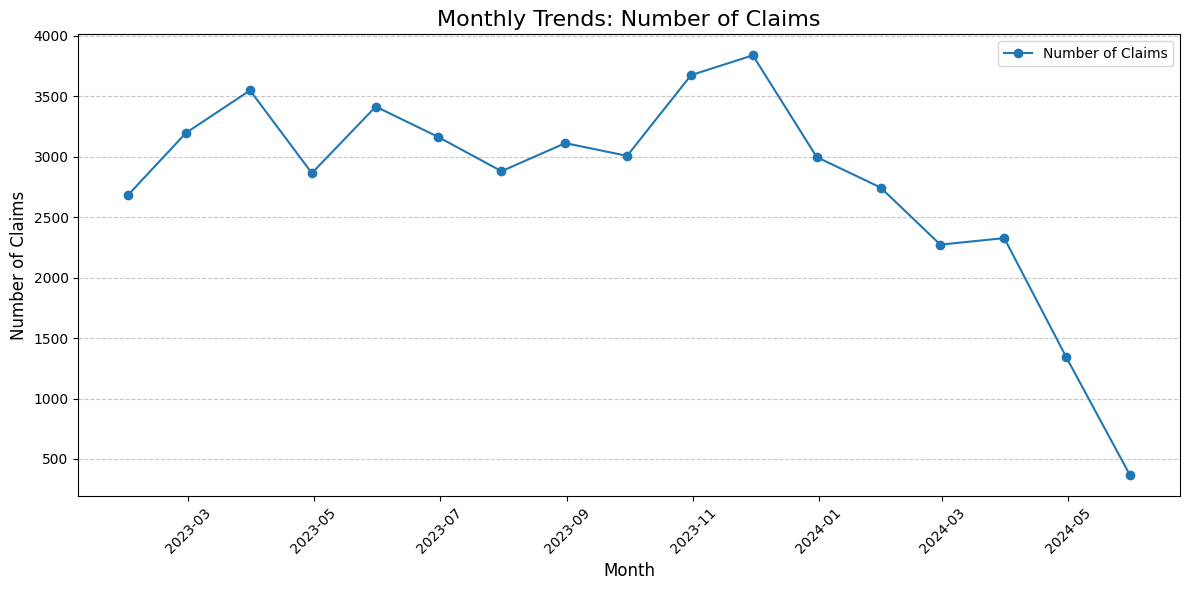

<Figure size 1200x600 with 0 Axes>

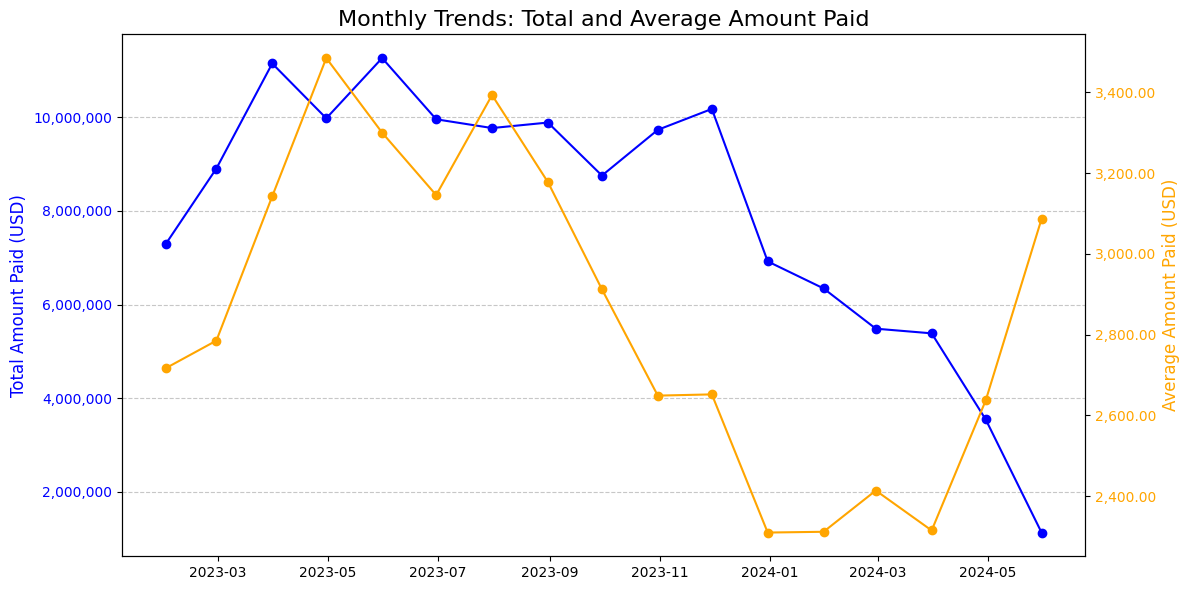

In [13]:
# Line Chart for Monthly Claims Count
plt.figure(figsize=(12, 6))
monthly_claims = monthly_trends['ID']['count']
plt.plot(monthly_claims.index, monthly_claims.values, marker='o', label='Number of Claims')
plt.title('Monthly Trends: Number of Claims', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Claims', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Line Chart for Total and Average Amount Paid (USD) by Month
plt.figure(figsize=(12, 6))
monthly_total_paid = monthly_trends['PAID_USD']['sum']
monthly_avg_paid = monthly_trends['PAID_USD']['mean']

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: Total Amount Paid
ax1.plot(monthly_total_paid.index, monthly_total_paid.values, marker='o', label='Total Amount Paid (USD)', color='blue')
ax1.set_ylabel('Total Amount Paid (USD)', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Secondary y-axis: Average Amount Paid
ax2 = ax1.twinx()
ax2.plot(monthly_avg_paid.index, monthly_avg_paid.values, marker='o', label='Average Amount Paid (USD)', color='orange')
ax2.set_ylabel('Average Amount Paid (USD)', fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))

# Titles and x-axis
plt.title('Monthly Trends: Total and Average Amount Paid', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Part 1.2: Before vs. After Joining Network (Normalized Time Frames)

# Define analysis window (3 months before and after joining)
ANALYSIS_WINDOW = pd.DateOffset(months=3)


def analyze_clinic_performance(clinic_name):
    """
    Analyzes clinic performance before and after joining network.
    Compares same months across years to account for seasonality.
    """
    
    clinic_data = CLINICS_IN_RED.get(clinic_name)
    if not clinic_data:
        return None
        
    # Get join date
    join_dates = [pd.to_datetime(d) for d in clinic_data['join_date'].values() if d]
    if not join_dates:
        return None
    join_date = min(join_dates)
    
    # Get clinic's last transaction date in 2024
    clinic_last_date = df_aggregated[
        (df_aggregated['CLINIC'] == clinic_name) & 
        (df_aggregated['DATE'].dt.year == 2024)
    ]['DATE'].max()
    
    if pd.isnull(clinic_last_date):
        return None
    
    # Define comparison periods
    after_start = join_date
    after_end = clinic_last_date
    
    before_start = after_start - pd.DateOffset(years=1)
    before_end = after_end - pd.DateOffset(years=1)
    
    # Get months to compare
    comparison_months = pd.date_range(
        after_start, 
        after_end, 
        freq='M'
    ).month.unique()
    
    # Create masks for before and after periods
    after_mask = (
        (df_aggregated['CLINIC'] == clinic_name) &
        (df_aggregated['DATE'] >= after_start) &
        (df_aggregated['DATE'] <= after_end)
    )
    
    before_mask = (
        (df_aggregated['CLINIC'] == clinic_name) &
        (df_aggregated['DATE'] >= before_start) &
        (df_aggregated['DATE'] <= before_end) &
        (df_aggregated['DATE'].dt.month.isin(comparison_months))  # Same months as after period
    )
    
    # Get claims for both periods
    after_claims = df_aggregated[after_mask].copy()
    before_claims = df_aggregated[before_mask].copy()
    
    if len(after_claims) == 0 or len(before_claims) == 0:
        return None
        
    # Calculate metrics for each period
    metrics = {}
    for period, claims in [('Before', before_claims), ('After', after_claims)]:
        metrics[period] = {
            'Claims': len(claims),
            'Claims per Month': len(claims) / len(comparison_months),
            'Median Price': claims['PAID_USD'].median(),
            'Mean Price': claims['PAID_USD'].mean(),
            'Total Paid': claims['PAID_USD'].sum(),
            'Unique Procedures': len(set([item for sublist in claims['PROCEDURES'] for item in sublist])),
            'Procedures per Claim': claims['PROCEDURES'].apply(len).mean()
        }
    
    # Calculate percentage changes
    changes = {
        'Claims Volume': ((metrics['After']['Claims'] / metrics['Before']['Claims']) - 1) * 100,
        'Monthly Claims': ((metrics['After']['Claims per Month'] / metrics['Before']['Claims per Month']) - 1) * 100,
        'Median Price': ((metrics['After']['Median Price'] / metrics['Before']['Median Price']) - 1) * 100,
        'Mean Price': ((metrics['After']['Mean Price'] / metrics['Before']['Mean Price']) - 1) * 100,
        'Procedures per Claim': ((metrics['After']['Procedures per Claim'] / metrics['Before']['Procedures per Claim']) - 1) * 100
    }
    
    # Determine performance category based on changes
    score = 0
    
    # Volume score: +1 if volume increased by 10%, -1 if decreased by 10%
    score += 1 if changes['Monthly Claims'] > 10 else -1 if changes['Monthly Claims'] < -10 else 0
    
    # Price score: +1 if prices decreased by 5%, -1 if increased by 5%
    avg_price_change = (changes['Median Price'] + changes['Mean Price']) / 2
    score += 1 if avg_price_change < -5 else -1 if avg_price_change > 5 else 0
    
    # Procedure diversity score: +1 if procedures per claim increased by 10%, -1 if decreased by 10%
    score += 1 if changes['Procedures per Claim'] > 10 else -1 if changes['Procedures per Claim'] < -10 else 0
    
    performance = "Overperformer" if score >= 2 else "Underperformer" if score <= -2 else "As Expected"
    
    return {
        'metrics': metrics,
        'changes': changes,
        'performance': performance,
        'tier': clinic_data.get('tier', 'Unknown'),
        'comparison_period': {
            'before': (before_start.strftime('%Y-%m-%d'), before_end.strftime('%Y-%m-%d')),
            'after': (after_start.strftime('%Y-%m-%d'), after_end.strftime('%Y-%m-%d')),
            'months_compared': sorted(comparison_months.tolist())
        }
    }

# Analyze all clinics
clinic_performances = {}
for clinic in CLINICS_IN_RED:
    result = analyze_clinic_performance(clinic)
    if result:
        clinic_performances[clinic] = result

# Print results
print("\nClinic Performance Analysis After Joining Network")
print("-" * 50)

# Group clinics by performance category
performance_categories = {
    "Overperformer": [],
    "As Expected": [],
    "Underperformer": []
}

for clinic, data in clinic_performances.items():
    performance_categories[data['performance']].append((clinic, data))

# Print results by category
for category, clinics in performance_categories.items():
    print(f"\n{category} Clinics ({len(clinics)}):")
    for clinic, data in clinics:
        print(f"\n  {clinic} (Tier {data['tier']}):")
        for metric, value in data['changes'].items():
            print(f"    {metric}: {value:+.1f}%")


Clinic Performance Analysis After Joining Network
--------------------------------------------------

Overperformer Clinics (4):

  CENTRO CLINICO FENIX SALUD,C.A. (Tier C):
    Claims Volume: +16.7%
    Monthly Claims: +16.7%
    Median Price: -21.6%
    Mean Price: -11.3%
    Procedures per Claim: +6.1%

  CENTRO CLINICO VISTA CALIFORNIA, C.A. (Tier C):
    Claims Volume: +217.4%
    Monthly Claims: +217.4%
    Median Price: +17.4%
    Mean Price: -12.0%
    Procedures per Claim: +13.7%

  GRUPO MEDICO LAS ACACIAS, C.A. (Tier B):
    Claims Volume: +168.8%
    Monthly Claims: +168.8%
    Median Price: -54.4%
    Mean Price: -37.9%
    Procedures per Claim: +1.8%

  SERVICIOS CLINICOS SANTA MONICA, C.A. (Tier B):
    Claims Volume: +13.2%
    Monthly Claims: +13.2%
    Median Price: -9.9%
    Mean Price: -23.6%
    Procedures per Claim: +5.0%

As Expected Clinics (6):

  A.C. CENTRO MEDICO DOCENTE LA TRINIDAD (Tier A):
    Claims Volume: +76.7%
    Monthly Claims: +76.7%
    Median P

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/324503956.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  comparison_months = pd.date_range(
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/324503956.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  comparison_months = pd.date_range(
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/324503956.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  comparison_months = pd.date_range(
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/324503956.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  comparison_months = pd.date_range(
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/324503956.py:40: FutureWarning: 'M' is deprecated and will be r

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/1482150977.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


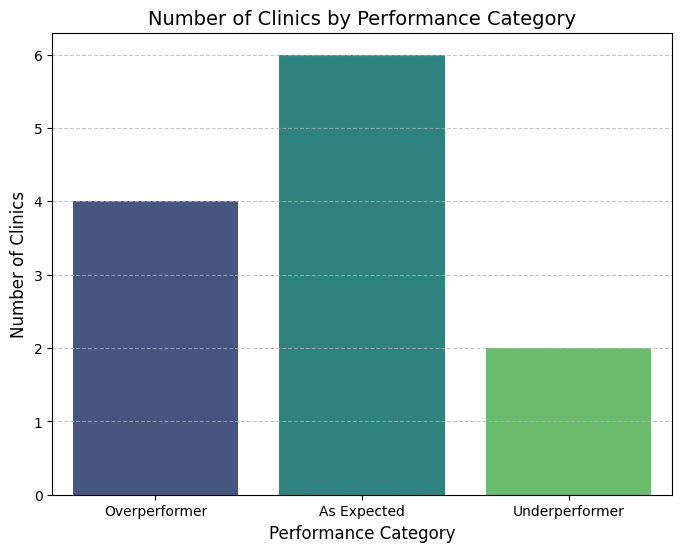

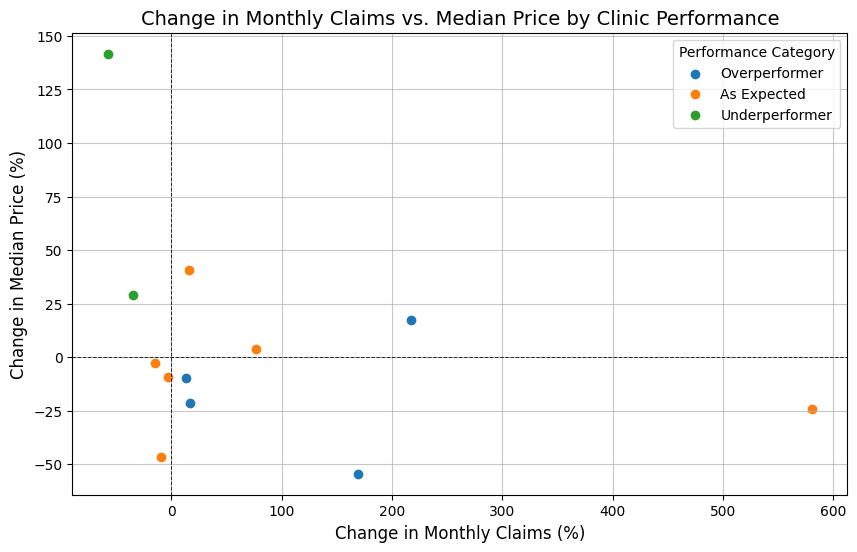

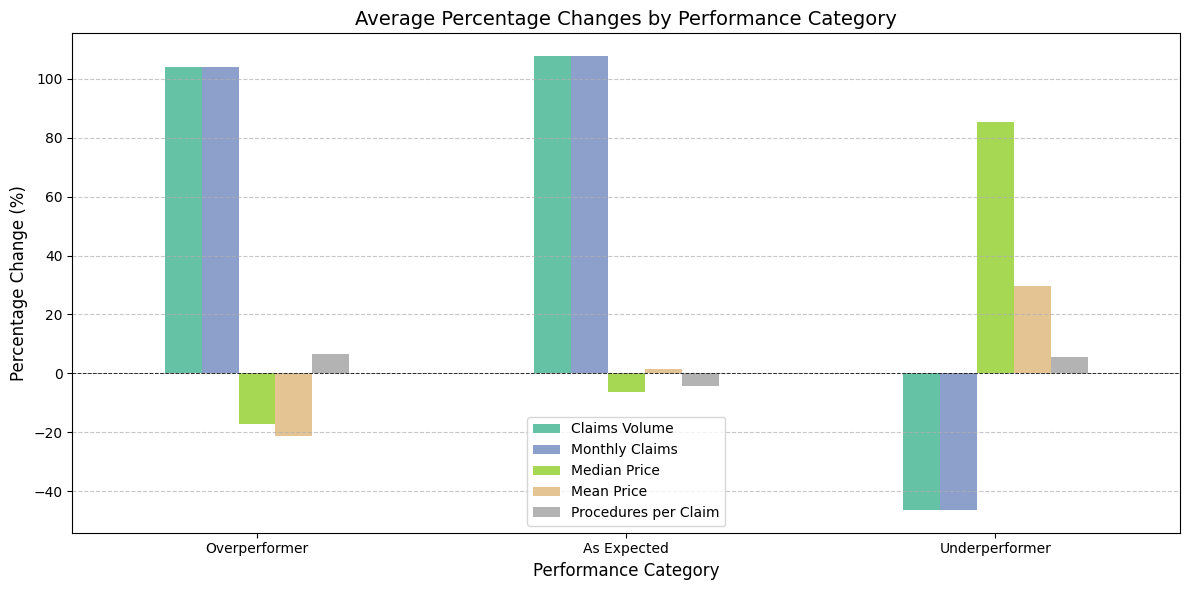

In [15]:
# 1. Bar Chart for Performance Categories
plt.figure(figsize=(8, 6))
performance_counts = {k: len(v) for k, v in performance_categories.items()}
sns.barplot(
    x=list(performance_counts.keys()),
    y=list(performance_counts.values()),
    palette="viridis"
)
plt.title('Number of Clinics by Performance Category', fontsize=14)
plt.xlabel('Performance Category', fontsize=12)
plt.ylabel('Number of Clinics', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Scatter Plot for Percentage Changes in Median Price vs. Monthly Claims
plt.figure(figsize=(10, 6))
for category, clinics in performance_categories.items():
    changes = [data['changes'] for _, data in clinics]
    plt.scatter(
        [c['Monthly Claims'] for c in changes],
        [c['Median Price'] for c in changes],
        label=category
    )
plt.axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.title('Change in Monthly Claims vs. Median Price by Clinic Performance', fontsize=14)
plt.xlabel('Change in Monthly Claims (%)', fontsize=12)
plt.ylabel('Change in Median Price (%)', fontsize=12)
plt.legend(title='Performance Category')
plt.grid(alpha=0.7)
plt.show()

# 3. Bar Chart for Average Changes by Performance Category
changes_summary = {}
for category, clinics in performance_categories.items():
    if len(clinics) > 0:
        avg_changes = pd.DataFrame([data['changes'] for _, data in clinics]).mean()
        changes_summary[category] = avg_changes

changes_df = pd.DataFrame(changes_summary).T

changes_df.plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title('Average Percentage Changes by Performance Category', fontsize=14)
plt.ylabel('Percentage Change (%)', fontsize=12)
plt.xlabel('Performance Category', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
#### Part 1.3: Comparison Among Clinics In vs. Out of Network By Tier

# Function to get tier metrics
def calculate_tier_metrics(tier):
    """Calculates metrics for in-network and out-of-network clinics within a tier"""
    
    # Get in-network clinics for this tier
    in_network = [
        clinic for clinic, data in CLINICS_IN_RED.items() 
        if data.get('tier') == tier
    ]
    
    # Get out-of-network comparison clinics for this tier
    out_network = TIER_COMPARSION.get(tier, [])
    
    # Initialize results
    results = {'IN': {}, 'OUT': {}}
    
    # Calculate metrics for each network status
    for status, clinics in [('IN', in_network), ('OUT', out_network)]:
        if not clinics:
            continue
            
        # Get claims for these clinics
        claims = df_aggregated[df_aggregated['CLINIC'].isin(clinics)]
        
        if len(claims) == 0:
            continue
            
        # Calculate metrics
        results[status] = {
            'Claims Volume': len(claims),
            'Clinics': len(clinics),
            'Claims per Clinic': len(claims) / len(clinics),
            'Median Price': claims['PAID_USD'].median(),
            'Mean Price': claims['PAID_USD'].mean(),
            'Price Range': f"${claims['PAID_USD'].min():,.2f} - ${claims['PAID_USD'].max():,.2f}",
            'Unique Procedures per Clinic': len(set([item for sublist in claims['PROCEDURES'] for item in sublist])) / len(clinics),
            'Procedures per Claim': claims['PROCEDURES'].apply(len).mean()
        }
    
    return results

# Get unique tiers from CLINICS_IN_RED
tiers = set()
for clinic_data in CLINICS_IN_RED.values():
    if 'tier' in clinic_data:
        tiers.add(clinic_data['tier'])

# Analyze each tier
print("\nTier-Based Performance Comparison")
print("-" * 50)

for tier in sorted(tiers):
    print(f"\nTier {tier}:")
    metrics = calculate_tier_metrics(tier)
    
    for network_status in ['IN', 'OUT']:
        if not metrics[network_status]:
            print(f"  No {network_status}-Network data available")
            continue
            
        print(f"\n  {network_status}-Network Metrics:")
        for metric, value in metrics[network_status].items():
            if isinstance(value, (int, float)):
                print(f"    {metric}: {value:,.2f}")
            else:
                print(f"    {metric}: {value}")
                
    # Calculate and print differences if both IN and OUT data exist
    if metrics['IN'] and metrics['OUT']:
        print("\n  Comparison (IN vs OUT):")
        comparable_metrics = [
            'Claims per Clinic',
            'Median Price',
            'Mean Price',
            'Procedures per Claim'
        ]
        
        for metric in comparable_metrics:
            diff_pct = ((metrics['IN'][metric] / metrics['OUT'][metric]) - 1) * 100
            print(f"    {metric}: {diff_pct:+.1f}%")


Tier-Based Performance Comparison
--------------------------------------------------

Tier A:

  IN-Network Metrics:
    Claims Volume: 15,659.00
    Clinics: 5.00
    Claims per Clinic: 3,131.80
    Median Price: 1,587.00
    Mean Price: 3,510.58
    Price Range: $12.00 - $145,506.00
    Unique Procedures per Clinic: 67.80
    Procedures per Claim: 1.84

  OUT-Network Metrics:
    Claims Volume: 2,085.00
    Clinics: 2.00
    Claims per Clinic: 1,042.50
    Median Price: 3,015.00
    Mean Price: 4,779.18
    Price Range: $75.00 - $116,685.00
    Unique Procedures per Clinic: 71.50
    Procedures per Claim: 2.46

  Comparison (IN vs OUT):
    Claims per Clinic: +200.4%
    Median Price: -47.4%
    Mean Price: -26.5%
    Procedures per Claim: -25.1%

Tier B:

  IN-Network Metrics:
    Claims Volume: 7,743.00
    Clinics: 10.00
    Claims per Clinic: 774.30
    Median Price: 1,144.00
    Mean Price: 2,396.15
    Price Range: $32.00 - $130,000.00
    Unique Procedures per Clinic: 22.50
 

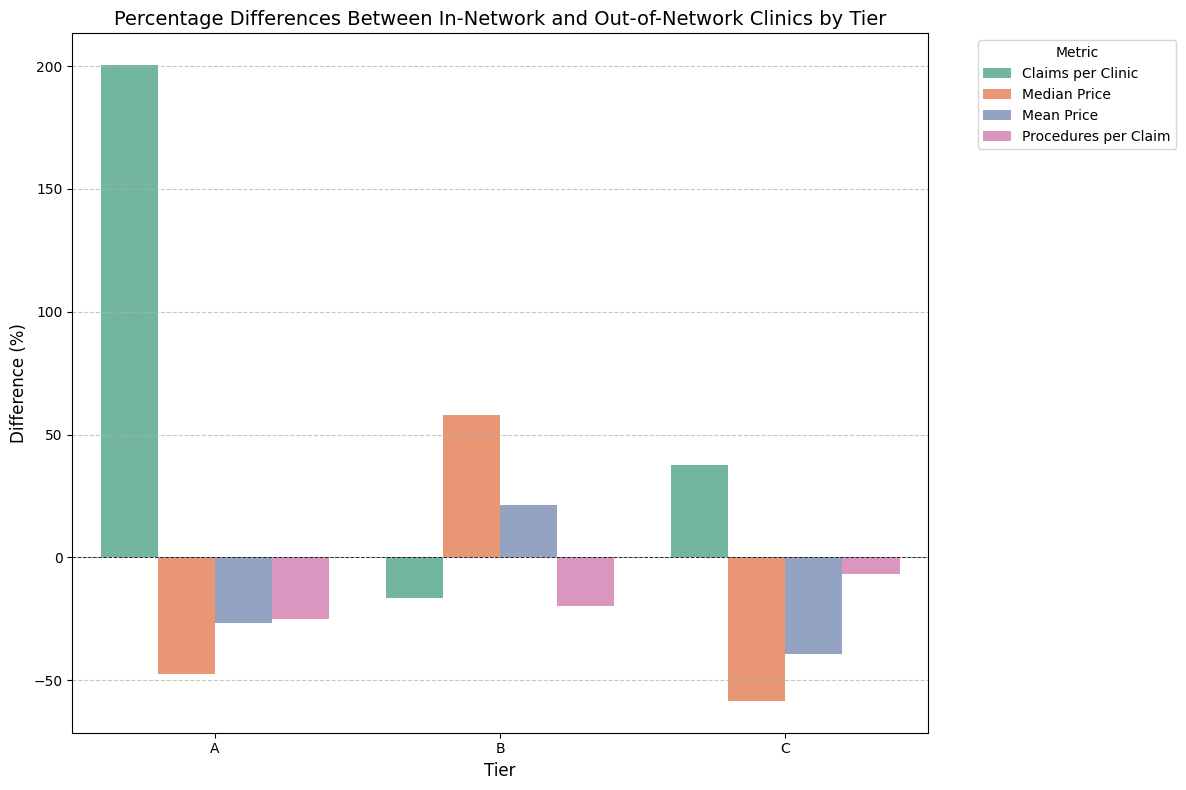

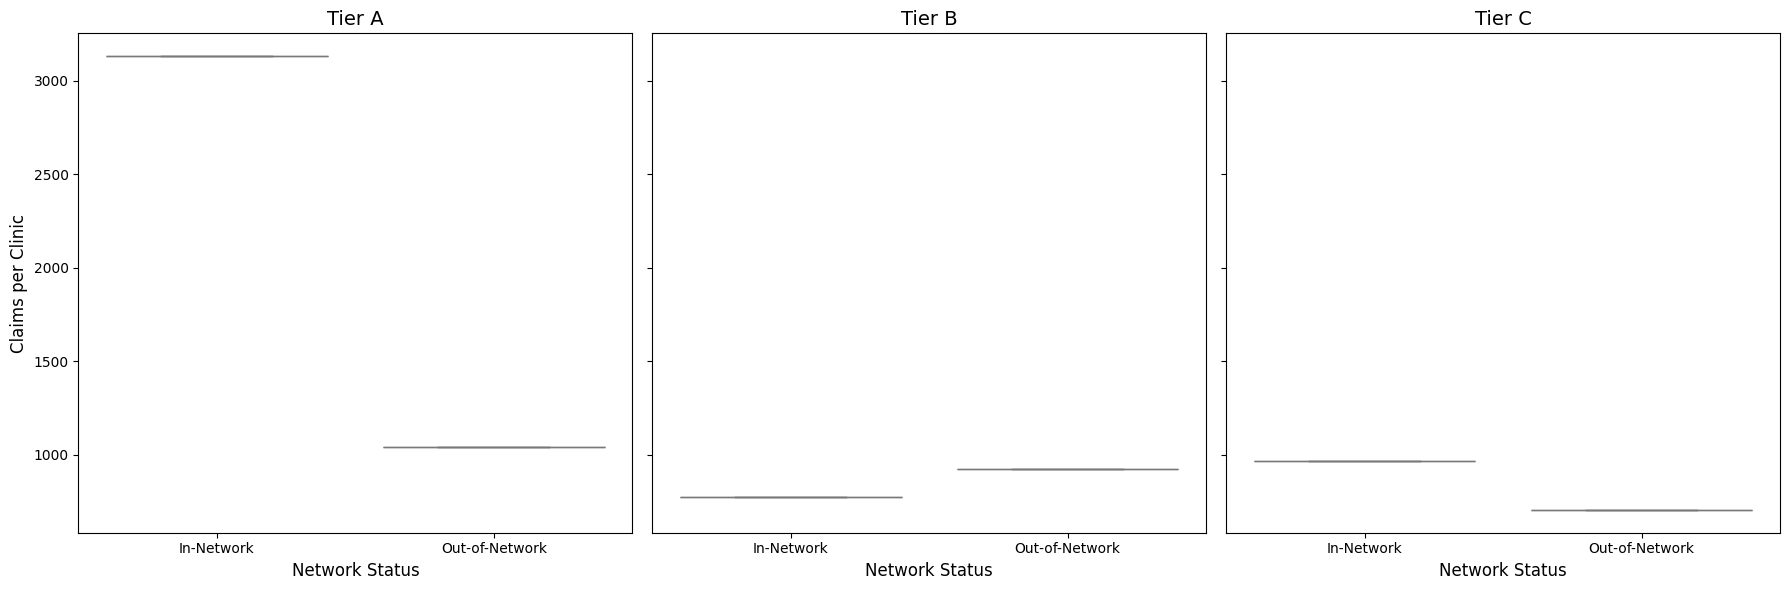

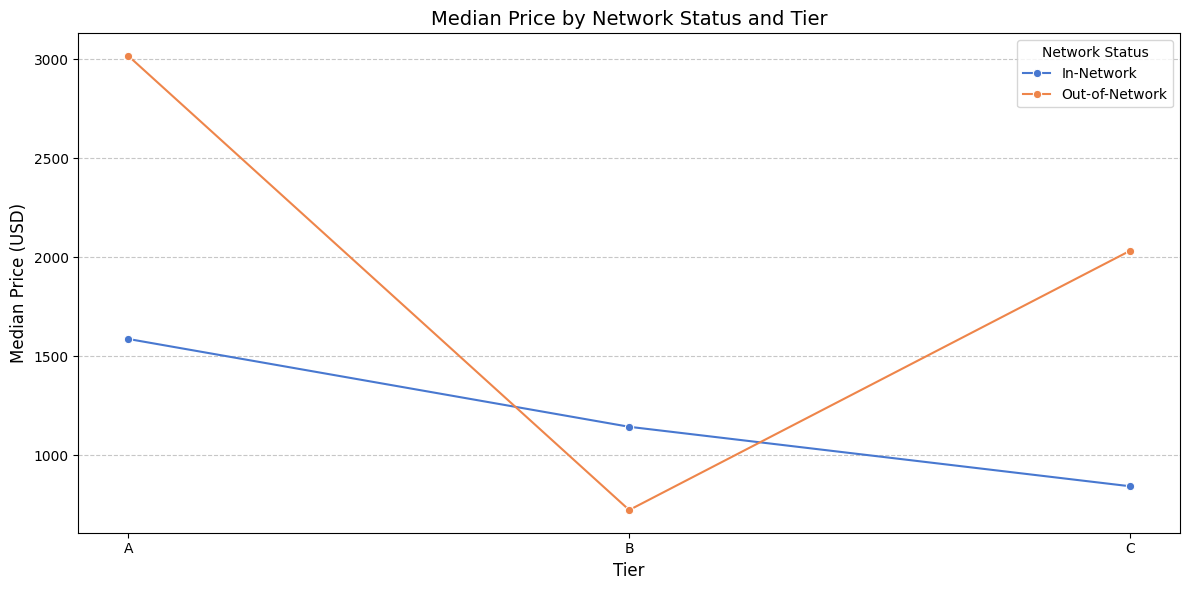

In [17]:
# Initialize data storage for visualization
comparison_data = []

# Iterate over each tier to collect comparison data
for tier in sorted(tiers):
    metrics = calculate_tier_metrics(tier)
    
    if metrics['IN'] and metrics['OUT']:
        for metric in ['Claims per Clinic', 'Median Price', 'Mean Price', 'Procedures per Claim']:
            in_metric = metrics['IN'][metric]
            out_metric = metrics['OUT'][metric]
            diff_pct = ((in_metric / out_metric) - 1) * 100
            
            comparison_data.append({
                'Tier': tier,
                'Metric': metric,
                'Difference (%)': diff_pct
            })

# Convert comparison data to DataFrame for visualization
comparison_df = pd.DataFrame(comparison_data)

# 1. Bar Chart for Percentage Differences by Metric Across Tiers
plt.figure(figsize=(12, 8))
sns.barplot(
    data=comparison_df,
    x='Tier',
    y='Difference (%)',
    hue='Metric',
    palette='Set2'
)
plt.axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.8)
plt.title('Percentage Differences Between In-Network and Out-of-Network Clinics by Tier', fontsize=14)
plt.xlabel('Tier', fontsize=12)
plt.ylabel('Difference (%)', fontsize=12)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Box Plot for Claims per Clinic by Network Status
tier_network_data = []

# Collect data for box plot
for tier in sorted(tiers):
    metrics = calculate_tier_metrics(tier)
    for network_status in ['IN', 'OUT']:
        if metrics[network_status]:
            tier_network_data.append({
                'Tier': tier,
                'Network': 'In-Network' if network_status == 'IN' else 'Out-of-Network',
                'Claims per Clinic': metrics[network_status]['Claims per Clinic']
            })

tier_network_df = pd.DataFrame(tier_network_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, tier in enumerate(tier_network_df['Tier'].unique()):
    subset = tier_network_df[tier_network_df['Tier'] == tier]
    sns.boxplot(
        data=subset,
        x='Network',
        y='Claims per Clinic',
        hue='Network',
        palette='coolwarm',
        ax=axes[idx],
        dodge=False,
        legend=False
    )
    axes[idx].set_title(f'Tier {tier}', fontsize=14)
    axes[idx].set_xlabel('Network Status', fontsize=12)
    if idx == 0:
        axes[idx].set_ylabel('Claims per Clinic', fontsize=12)

plt.tight_layout()
plt.show()

# 3. Line Plot for Median Price Across Tiers
median_price_data = []

# Collect data for line plot
for tier in sorted(tiers):
    metrics = calculate_tier_metrics(tier)
    for network_status in ['IN', 'OUT']:
        if metrics[network_status]:
            median_price_data.append({
                'Tier': tier,
                'Network': 'In-Network' if network_status == 'IN' else 'Out-of-Network',
                'Median Price': metrics[network_status]['Median Price']
            })

median_price_df = pd.DataFrame(median_price_data)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=median_price_df,
    x='Tier',
    y='Median Price',
    hue='Network',
    marker='o',
    palette='muted'
)
plt.title('Median Price by Network Status and Tier', fontsize=14)
plt.xlabel('Tier', fontsize=12)
plt.ylabel('Median Price (USD)', fontsize=12)
plt.legend(title='Network Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
def analyze_correlations(df):
    """Analyzes correlations between key metrics"""
    
    # First, ensure we have the insurance coverage data
    df_with_coverage = df.merge(
        df_normalized[['ID', 'INSURANCE_COVERAGE']], 
        on='ID', 
        how='left'
    )
    
    # Define columns we want to analyze
    available_columns = ['PAID_USD', 'PROCEDURE_CLUSTER']
    if 'INSURANCE_COVERAGE' in df_with_coverage.columns:
        available_columns.append('INSURANCE_COVERAGE')
    
    # Calculate correlations only for available columns
    corr_matrix = df_with_coverage[available_columns].corr()
    
    print("\nCorrelation Analysis:")
    print("-" * 50)
    print(corr_matrix.round(3))
        
    print("\nKey Insights:")
    
    # Create a multi-level column structure for cluster statistics
    cluster_stats_columns = pd.MultiIndex.from_product([['PAID_USD', 'INSURANCE_COVERAGE'], ['mean', 'median']])
    cluster_stats = pd.DataFrame(columns=cluster_stats_columns)
    
    # Fill payment statistics
    payment_stats = df_with_coverage.groupby('PROCEDURE_CLUSTER')['PAID_USD'].agg(['mean', 'median']).round(2)
    cluster_stats[('PAID_USD', 'mean')] = payment_stats['mean']
    cluster_stats[('PAID_USD', 'median')] = payment_stats['median']
    
    # Fill insurance coverage statistics if available
    if 'INSURANCE_COVERAGE' in df_with_coverage.columns:
        coverage_stats = df_with_coverage.groupby('PROCEDURE_CLUSTER')['INSURANCE_COVERAGE'].agg(['mean', 'median']).round(2)
        cluster_stats[('INSURANCE_COVERAGE', 'mean')] = coverage_stats['mean']
        cluster_stats[('INSURANCE_COVERAGE', 'median')] = coverage_stats['median']
    
    print("\nProcedure Cluster Statistics:")
    print(cluster_stats)
    
    # Only do insurance coverage analysis if the column exists and has valid data
    if 'INSURANCE_COVERAGE' in df_with_coverage.columns and df_with_coverage['INSURANCE_COVERAGE'].notna().any():
        # Remove zeros and create bins
        valid_coverage = df_with_coverage[df_with_coverage['INSURANCE_COVERAGE'] > 0]
        
        try:
            # Create bins with handling for duplicates
            df_with_coverage['COVERAGE_BIN'] = pd.qcut(
                valid_coverage['INSURANCE_COVERAGE'], 
                q=5, 
                labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
                duplicates='drop'
            )
            
            coverage_stats = df_with_coverage.groupby('COVERAGE_BIN').agg({
                'PAID_USD': ['mean', 'median', 'count'],
                'PROCEDURE_CLUSTER': 'nunique'
            }).round(2)
            
            coverage_stats.columns = [
                'Mean Payment', 'Median Payment', 'Claim Count', 
                'Unique Procedure Types'
            ]
            
            print("\nPayment Statistics by Insurance Coverage Level:")
            print(coverage_stats)
            
            # Calculate price ratios (amount paid vs coverage) for non-zero coverage
            valid_coverage['PRICE_RATIO'] = (
                valid_coverage['PAID_USD'] / 
                valid_coverage['INSURANCE_COVERAGE']
            )
            
            ratio_stats = valid_coverage.groupby('COVERAGE_BIN')['PRICE_RATIO'].agg([
                'mean', 'median'
            ]).round(3)
            
            print("\nPrice to Coverage Ratio by Coverage Level:")
            print(ratio_stats)
            
        except Exception as e:
            print(f"\nWarning: Could not complete insurance coverage analysis: {str(e)}")
            print("This might be due to insufficient variation in coverage values.")
    else:
        print("\nNote: Insurance coverage analysis skipped - no valid coverage data available")

    
    # Return correlation matrix and data for visualization
    return corr_matrix, df_with_coverage

# Apply clustering to procedures
procedure_clusters = cluster_procedures(df_aggregated['PROCEDURES'])
df_aggregated['PROCEDURE_CLUSTER'] = df_aggregated['PROCEDURES'].apply(
    lambda x: procedure_clusters.get(tuple(x), -1)
)

# Run correlation analysis
analyze_correlations(df_aggregated)


Correlation Analysis:
--------------------------------------------------
                    PAID_USD  PROCEDURE_CLUSTER  INSURANCE_COVERAGE
PAID_USD               1.000              0.131               0.106
PROCEDURE_CLUSTER      0.131              1.000              -0.165
INSURANCE_COVERAGE     0.106             -0.165               1.000

Key Insights:

Procedure Cluster Statistics:
                   PAID_USD           INSURANCE_COVERAGE            
                       mean    median               mean      median
PROCEDURE_CLUSTER                                                   
-1                 3257.100  1518.500        1101810.220 1000000.000
 0                 4467.100  4437.500         134025.530  100000.000
 1                 6587.780  5266.000         111152.220  100000.000
 2                 1242.920   810.000         108535.940  100000.000
 3                 4468.320  2730.000         112268.280  100000.000
 4                 6481.590  5240.000         111850.780

(                    PAID_USD  PROCEDURE_CLUSTER  INSURANCE_COVERAGE
 PAID_USD               1.000              0.131               0.106
 PROCEDURE_CLUSTER      0.131              1.000              -0.165
 INSURANCE_COVERAGE     0.106             -0.165               1.000,
                                                       ID  \
 0      00673554EMBARAZO, PARTO Y PUERPERIOoctubre2023...   
 1      00673554EMBARAZO, PARTO Y PUERPERIOoctubre2023...   
 2             00673554NAUSEA Y VOMITOabril2023EMERGENCIA   
 3             00673554NAUSEA Y VOMITOabril2023EMERGENCIA   
 4      069701191TRAUMATISMO SUPERFICIAL DE LA CADERA ...   
 ...                                                  ...   
 97879  YC703579EMBARAZO, PARTO Y PUERPERIOnoviembre20...   
 97880  YC703579EMBARAZO, PARTO Y PUERPERIOnoviembre20...   
 97881       YC703579INFECCION VIRALoctubre2023EMERGENCIA   
 97882       YC703579INFECCION VIRALoctubre2023EMERGENCIA   
 97883       YC703579INFECCION VIRALoctubre2023EMERG


Correlation Analysis:
--------------------------------------------------
                    PAID_USD  PROCEDURE_CLUSTER  INSURANCE_COVERAGE
PAID_USD               1.000              0.131               0.106
PROCEDURE_CLUSTER      0.131              1.000              -0.165
INSURANCE_COVERAGE     0.106             -0.165               1.000

Key Insights:

Procedure Cluster Statistics:
                   PAID_USD           INSURANCE_COVERAGE            
                       mean    median               mean      median
PROCEDURE_CLUSTER                                                   
-1                 3257.100  1518.500        1101810.220 1000000.000
 0                 4467.100  4437.500         134025.530  100000.000
 1                 6587.780  5266.000         111152.220  100000.000
 2                 1242.920   810.000         108535.940  100000.000
 3                 4468.320  2730.000         112268.280  100000.000
 4                 6481.590  5240.000         111850.780

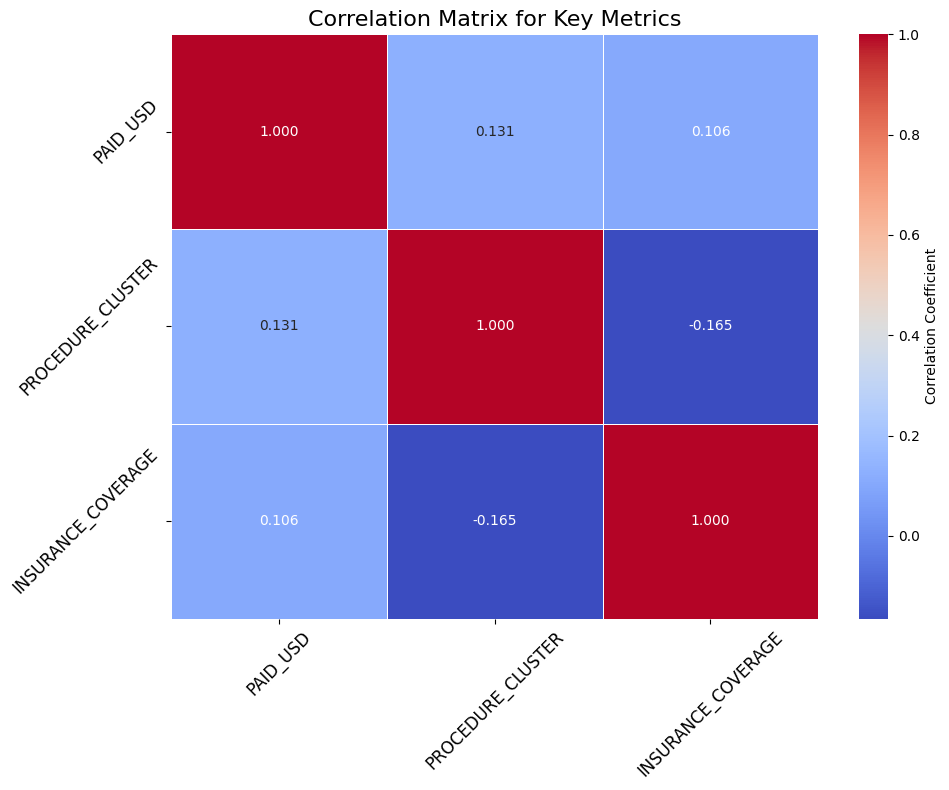

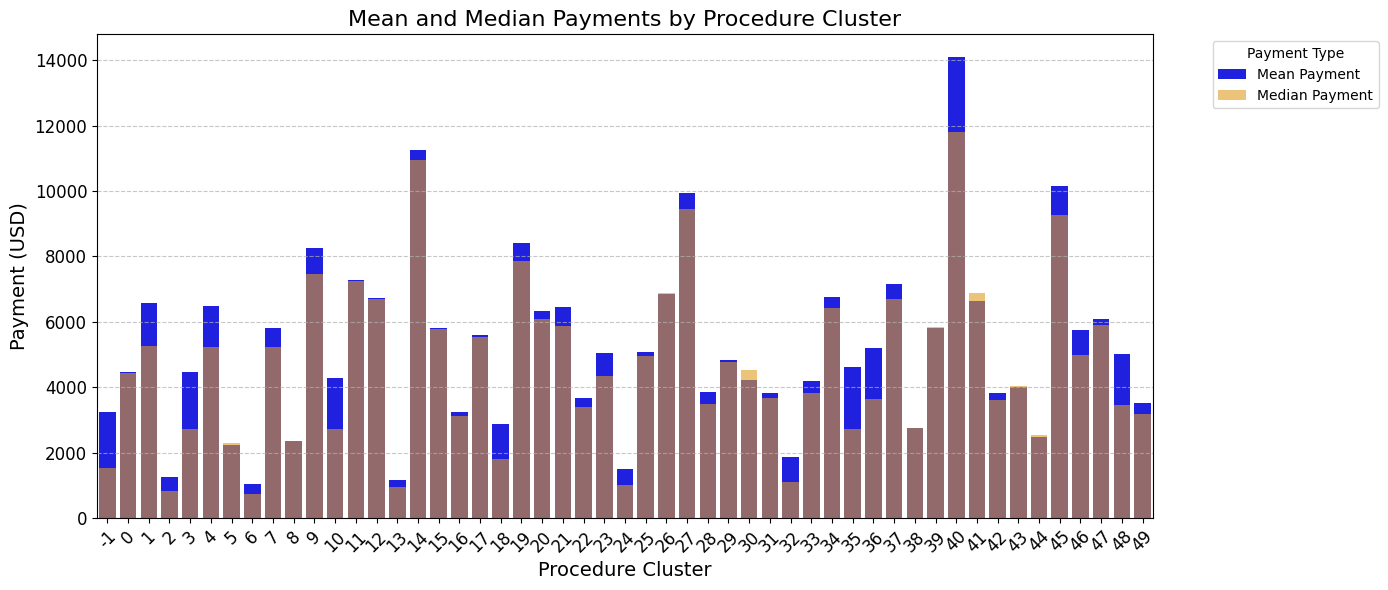

In [19]:
# Run correlation analysis and retrieve results
corr_matrix, df_with_coverage = analyze_correlations(df_aggregated)

# Visualization for Correlation Analysis and Insurance Coverage Analysis

# 1. Heatmap for Correlation Matrix
# Visualizes correlations between PAID_USD, PROCEDURE_CLUSTER, and INSURANCE_COVERAGE
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix for Key Metrics', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# 2. Bar Chart for Procedure Cluster Statistics
# Displays mean and median payments by procedure cluster
cluster_stats = df_with_coverage.groupby('PROCEDURE_CLUSTER')['PAID_USD'].agg(['mean', 'median']).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(
    x='PROCEDURE_CLUSTER',
    y='mean',
    data=cluster_stats,
    color='blue',
    label='Mean Payment'
)
sns.barplot(
    x='PROCEDURE_CLUSTER',
    y='median',
    data=cluster_stats,
    color='orange',
    label='Median Payment',
    alpha=0.6
)
plt.title('Mean and Median Payments by Procedure Cluster', fontsize=16)
plt.xlabel('Procedure Cluster', fontsize=14)
plt.ylabel('Payment (USD)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
### Part 2: Extended Analysis Using Additional Variables

def analyze_extended_metrics():
    """Comprehensive analysis using additional variables from original dataset"""
    
    # Read original dataset
    df_original = pd.read_csv('data.csv', encoding='utf-8', low_memory=False)
    
    # Merge with aggregated data
    df_extended = df_aggregated.merge(
        df_original[[
            'CONCATENADO',  # This is our ID
            'especialidad',
            'edad',
            'tipo de poliza',
            'Producto',
            'tratamiento',
            'sucursal',
            'Categoría',
            'ramo'
        ]],
        left_on='ID',
        right_on='CONCATENADO',
        how='left'
    ).rename(columns={
        'especialidad': 'SPECIALTY',
        'edad': 'AGE',
        'tipo de poliza': 'POLICY_TYPE',
        'Producto': 'PRODUCT',
        'tratamiento': 'TREATMENT',
        'sucursal': 'BRANCH',
        'Categoría': 'CATEGORY',
        'ramo': 'BUSINESS_LINE'
    })
    
    # Convert IN_RED to numeric (True -> 1, False -> 0)
    df_extended['IN_RED'] = df_extended['IN_RED'].astype(int)
    
    print("\nExtended Analysis Results")
    print("=" * 50)
    
    # 1. Medical Specialty Analysis
    print("\n1. Medical Specialty Analysis")
    print("-" * 30)
    
    # Count and financial metrics separately
    specialty_counts = df_extended.groupby('SPECIALTY').size().sort_values(ascending=False)
    specialty_financials = df_extended.groupby('SPECIALTY')['PAID_USD'].agg([
        'mean', 'median', 'std'
    ]).round(2)
    
    # Now IN_RED is numeric, so mean calculation will work
    specialty_network = df_extended.groupby('SPECIALTY')['IN_RED'].mean().round(2)
    
    # Combine metrics
    specialty_metrics = pd.concat([
        specialty_counts.rename('count'),
        specialty_financials,
        specialty_network.rename('network_rate')
    ], axis=1)
    
    print("\nTop 10 Specialties by Volume:")
    print(specialty_metrics.head(10))
    
    # Network impact by specialty
    print("\nNetwork Impact Analysis:")
    network_impact = df_extended.pivot_table(
        values='PAID_USD',
        index='SPECIALTY',
        columns='IN_RED',
        aggfunc=['mean', 'count']
    ).round(2)
    
    # Calculate price changes where we have both in and out of network data
    network_impact['price_change_pct'] = (
        (network_impact[('mean', 1)] - network_impact[('mean', 0)]) / 
        network_impact[('mean', 0)] * 100
    ).round(2)
    
    print("\nTop 5 Specialties with Largest Price Reductions in Network:")
    valid_changes = network_impact[
        network_impact['price_change_pct'].notna() & 
        (network_impact[('count', 1)] >= 10) &  # Minimum sample size
        (network_impact[('count', 0)] >= 10)
    ]
    print(valid_changes.nlargest(5, 'price_change_pct')[['price_change_pct']])
    
    # 2. Demographics Analysis
    print("\n2. Demographics Analysis")
    print("-" * 30)
    
    # Age analysis
    df_extended['AGE'] = pd.to_numeric(df_extended['AGE'], errors='coerce')
    age_bins = [0, 18, 35, 50, 65, float('inf')]
    age_labels = ['0-18', '19-35', '36-50', '51-65', '65+']
    df_extended['AGE_GROUP'] = pd.cut(df_extended['AGE'], bins=age_bins, labels=age_labels)
    
    age_metrics = pd.DataFrame({
        'Claims': df_extended.groupby('AGE_GROUP').size(),
        'Avg_Cost': df_extended.groupby('AGE_GROUP')['PAID_USD'].mean().round(2),
        'Network_Rate': df_extended.groupby('AGE_GROUP')['IN_RED'].mean().round(2),
        'Avg_Procedures': df_extended.groupby('AGE_GROUP')['PROCEDURES'].apply(
            lambda x: np.mean([len(p) for p in x])
        ).round(2)
    })
    
    print("\nMetrics by Age Group:")
    print(age_metrics)
    
    # 3. Treatment Analysis
    print("\n3. Treatment Pattern Analysis")
    print("-" * 30)
    
    # Spanish stop words list
    spanish_stop_words = [
        'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas'
    ]
    
    # Cluster treatments using NLP
    vectorizer = TfidfVectorizer(
        stop_words=spanish_stop_words,
        ngram_range=(1, 2),
        max_features=1000
    )
    
    # Handle NaN values in treatments
    treatments_text = df_extended['TREATMENT'].fillna('')
    treatment_vectors = vectorizer.fit_transform(treatments_text)
    
    n_clusters = min(len(df_extended) // 20, 30)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_extended['TREATMENT_CLUSTER'] = kmeans.fit_predict(treatment_vectors)
    
    # Calculate metrics by treatment cluster
    treatment_metrics = pd.DataFrame({
        'Claims': df_extended.groupby('TREATMENT_CLUSTER').size(),
        'Avg_Cost': df_extended.groupby('TREATMENT_CLUSTER')['PAID_USD'].mean().round(2),
        'Network_Rate': df_extended.groupby('TREATMENT_CLUSTER')['IN_RED'].mean().round(2),
        'Common_Treatments': df_extended.groupby('TREATMENT_CLUSTER')['TREATMENT'].agg(
            lambda x: x.value_counts().head(3).index.tolist()
        )
    })
    
    print("\nTop 5 Treatment Clusters by Volume:")
    print(treatment_metrics.nlargest(5, 'Claims'))
    
    # 4. Business Line Analysis
    print("\n4. Business Line Analysis")
    print("-" * 30)
    
    business_metrics = pd.DataFrame({
        'Claims': df_extended.groupby('BUSINESS_LINE').size(),
        'Avg_Cost': df_extended.groupby('BUSINESS_LINE')['PAID_USD'].mean().round(2),
        'Network_Rate': df_extended.groupby('BUSINESS_LINE')['IN_RED'].mean().round(2),
        'Avg_Procedures': df_extended.groupby('BUSINESS_LINE')['PROCEDURES'].apply(
            lambda x: np.mean([len(p) for p in x])
        ).round(2)
    })
    
    print("\nMetrics by Business Line:")
    print(business_metrics)
    
    # 5. Cross-Analysis
    print("\n5. Cross-Analysis: Average Cost by Specialty and Business Line")
    print("-" * 30)
    
    cross_analysis = pd.pivot_table(
        df_extended,
        values='PAID_USD',
        index='SPECIALTY',
        columns='BUSINESS_LINE',
        aggfunc='mean'
    ).round(2)
    
    print("\nTop 5 Most Expensive Specialty-Business Line Combinations:")
    flat_cross = cross_analysis.unstack()
    print(flat_cross.nlargest(5))
    
    return {
        'specialty_metrics': specialty_metrics,
        'age_metrics': age_metrics,
        'treatment_metrics': treatment_metrics,
        'business_metrics': business_metrics,
        'cross_analysis': cross_analysis,
        'df_extended': df_extended
    }

# Run the extended analysis
extended_results = analyze_extended_metrics()


Extended Analysis Results

1. Medical Specialty Analysis
------------------------------

Top 10 Specialties by Volume:
                           count     mean   median       std  network_rate
SPECIALTY                                                                 
MEDICINA INTERNA           36330 1961.160  914.000  3455.650         0.030
TRAUMATOLOGIA              17045 4075.430 2779.000  4421.540         0.040
CIRUGIA GENERAL             6457 5066.780 4769.000  3576.010         0.050
PEDIATRIA                   5796 2805.360  996.000  6996.550         0.060
OFTALMOLOGIA                3850 2334.720 2309.000   901.060         0.060
OBSTETRICIA                 2994 4105.340 4413.000  1511.410         0.020
OTORRINOLARINGOLOGIA        2745 4344.190 4765.000  2722.500         0.040
ONCOLOGIA                   2370 7994.610 5115.000 11524.140         0.040
UROLOGIA                    2118 5171.820 4354.000  3954.670         0.040
TRAUMATOLOGIA ORTOPEDISTA   1756 4493.240 2629.500  543

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3695365577.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Claims': df_extended.groupby('AGE_GROUP').size(),
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3695365577.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Avg_Cost': df_extended.groupby('AGE_GROUP')['PAID_USD'].mean().round(2),
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3695365577.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 


Top 5 Treatment Clusters by Volume:
                   Claims  Avg_Cost  Network_Rate  \
TREATMENT_CLUSTER                                   
1                   49739  3667.130         0.000   
0                   27152  1204.820         0.060   
2                    7523  6998.520         0.070   
3                    6783  4252.910         0.060   
4                    3958  3786.260         0.140   

                                              Common_Treatments  
TREATMENT_CLUSTER                                                
1                                                            []  
0                                     [Tratamiento Ambulatorio]  
2                  [Tratamiento Quirúrgico con Hospitalización]  
3                             [Tratamiento con Hospitalización]  
4                          [Tratamiento Quirúrgico Ambulatorio]  

4. Business Line Analysis
------------------------------

Metrics by Business Line:
               Claims  Avg_Cost  Network_Rat

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)



Extended Analysis Results

1. Medical Specialty Analysis
------------------------------

Top 10 Specialties by Volume:
                           count     mean   median       std  network_rate
SPECIALTY                                                                 
MEDICINA INTERNA           36330 1961.160  914.000  3455.650         0.030
TRAUMATOLOGIA              17045 4075.430 2779.000  4421.540         0.040
CIRUGIA GENERAL             6457 5066.780 4769.000  3576.010         0.050
PEDIATRIA                   5796 2805.360  996.000  6996.550         0.060
OFTALMOLOGIA                3850 2334.720 2309.000   901.060         0.060
OBSTETRICIA                 2994 4105.340 4413.000  1511.410         0.020
OTORRINOLARINGOLOGIA        2745 4344.190 4765.000  2722.500         0.040
ONCOLOGIA                   2370 7994.610 5115.000 11524.140         0.040
UROLOGIA                    2118 5171.820 4354.000  3954.670         0.040
TRAUMATOLOGIA ORTOPEDISTA   1756 4493.240 2629.500  543

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3695365577.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Claims': df_extended.groupby('AGE_GROUP').size(),
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3695365577.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Avg_Cost': df_extended.groupby('AGE_GROUP')['PAID_USD'].mean().round(2),
/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/3695365577.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 


Top 5 Treatment Clusters by Volume:
                   Claims  Avg_Cost  Network_Rate  \
TREATMENT_CLUSTER                                   
1                   49739  3667.130         0.000   
0                   27152  1204.820         0.060   
2                    7523  6998.520         0.070   
3                    6783  4252.910         0.060   
4                    3958  3786.260         0.140   

                                              Common_Treatments  
TREATMENT_CLUSTER                                                
1                                                            []  
0                                     [Tratamiento Ambulatorio]  
2                  [Tratamiento Quirúrgico con Hospitalización]  
3                             [Tratamiento con Hospitalización]  
4                          [Tratamiento Quirúrgico Ambulatorio]  

4. Business Line Analysis
------------------------------

Metrics by Business Line:
               Claims  Avg_Cost  Network_Rat

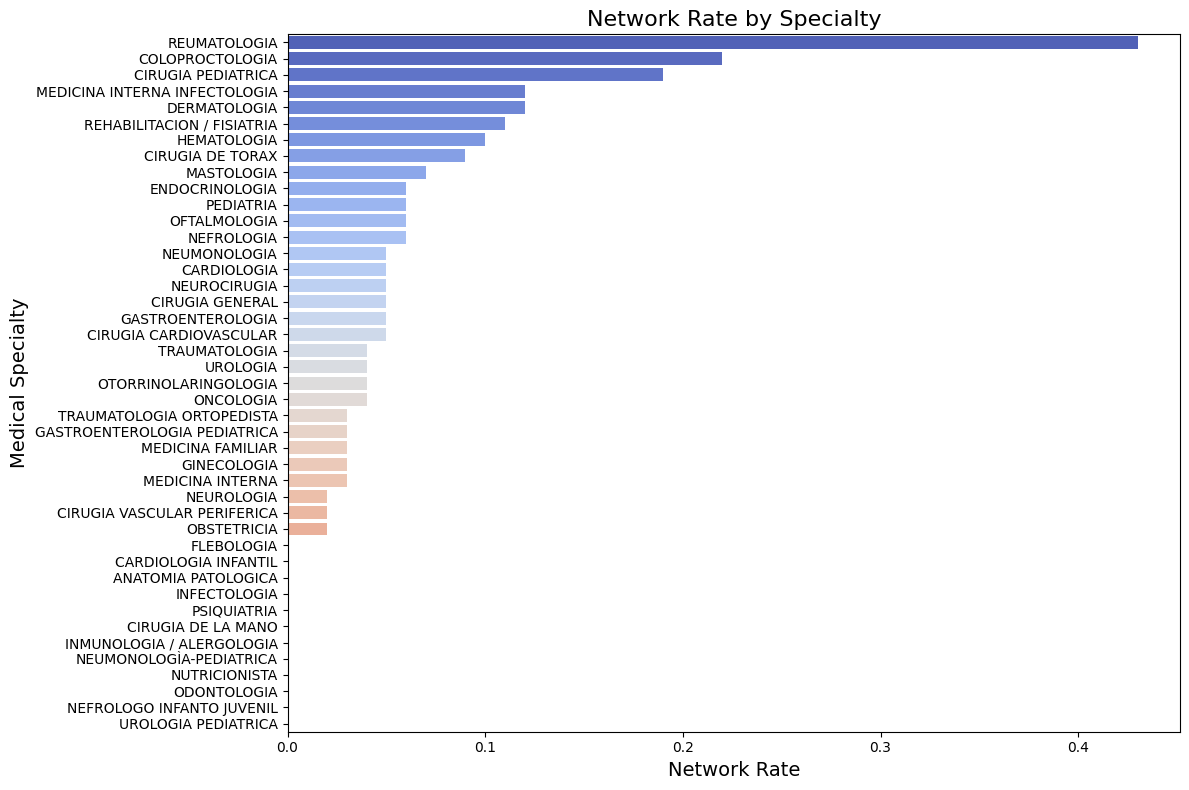

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/2103469409.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_extended.groupby(['AGE_GROUP', 'SPECIALTY'])['IN_RED']


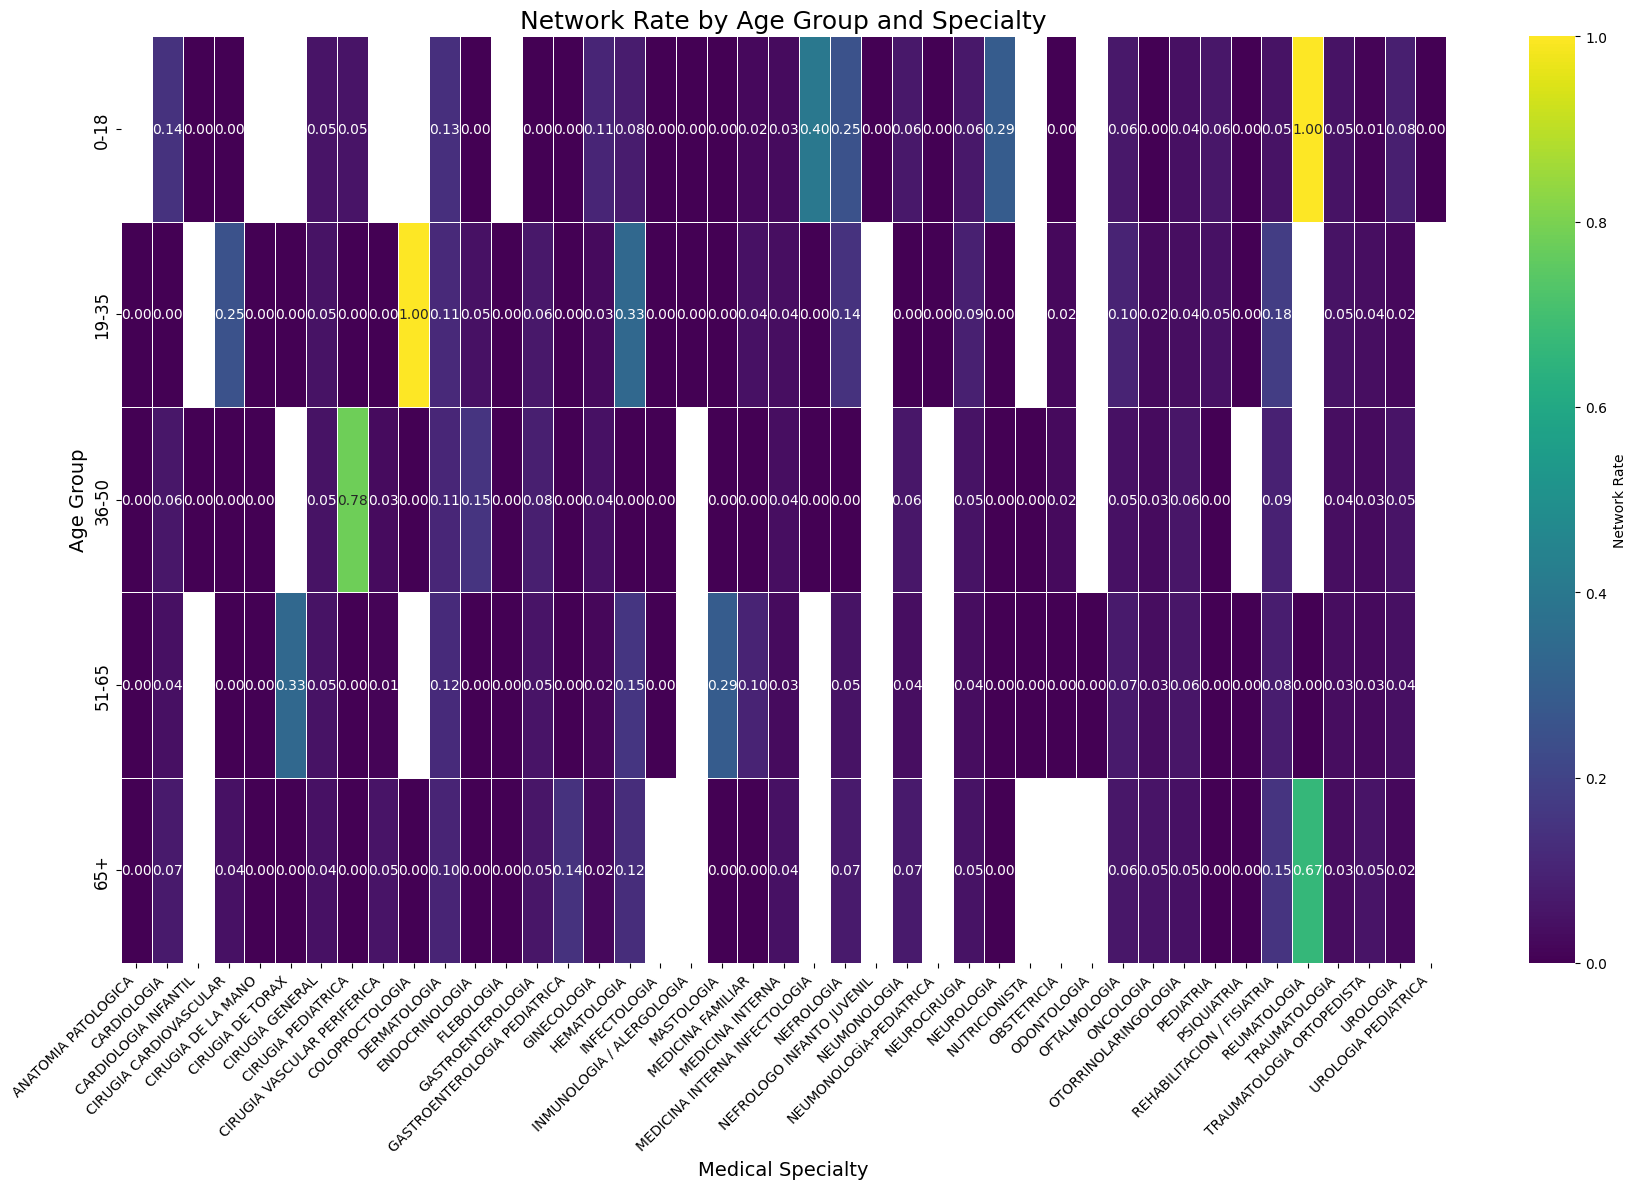

/var/folders/w6/j9smqmyd5ms4j8syyh7m4l7r0000gn/T/ipykernel_80746/2103469409.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


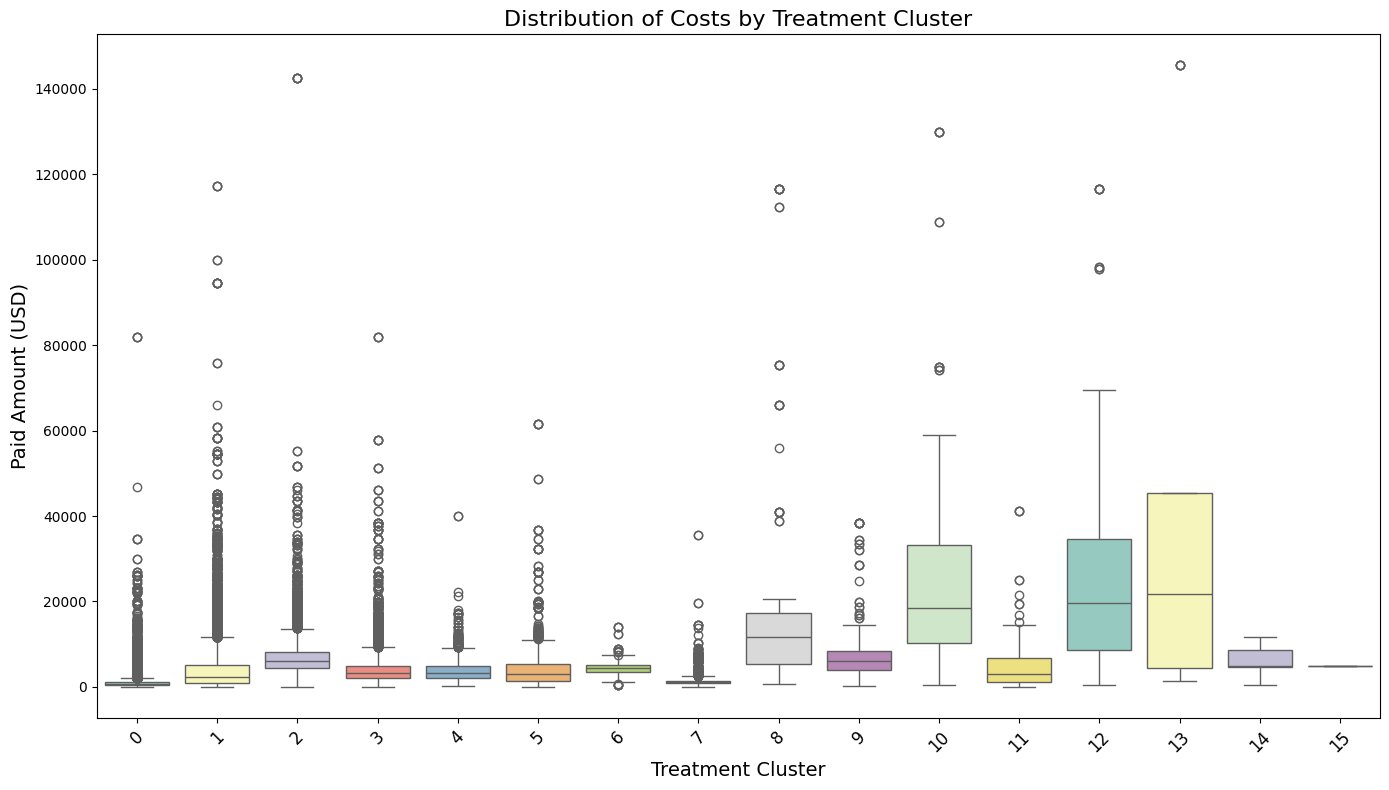

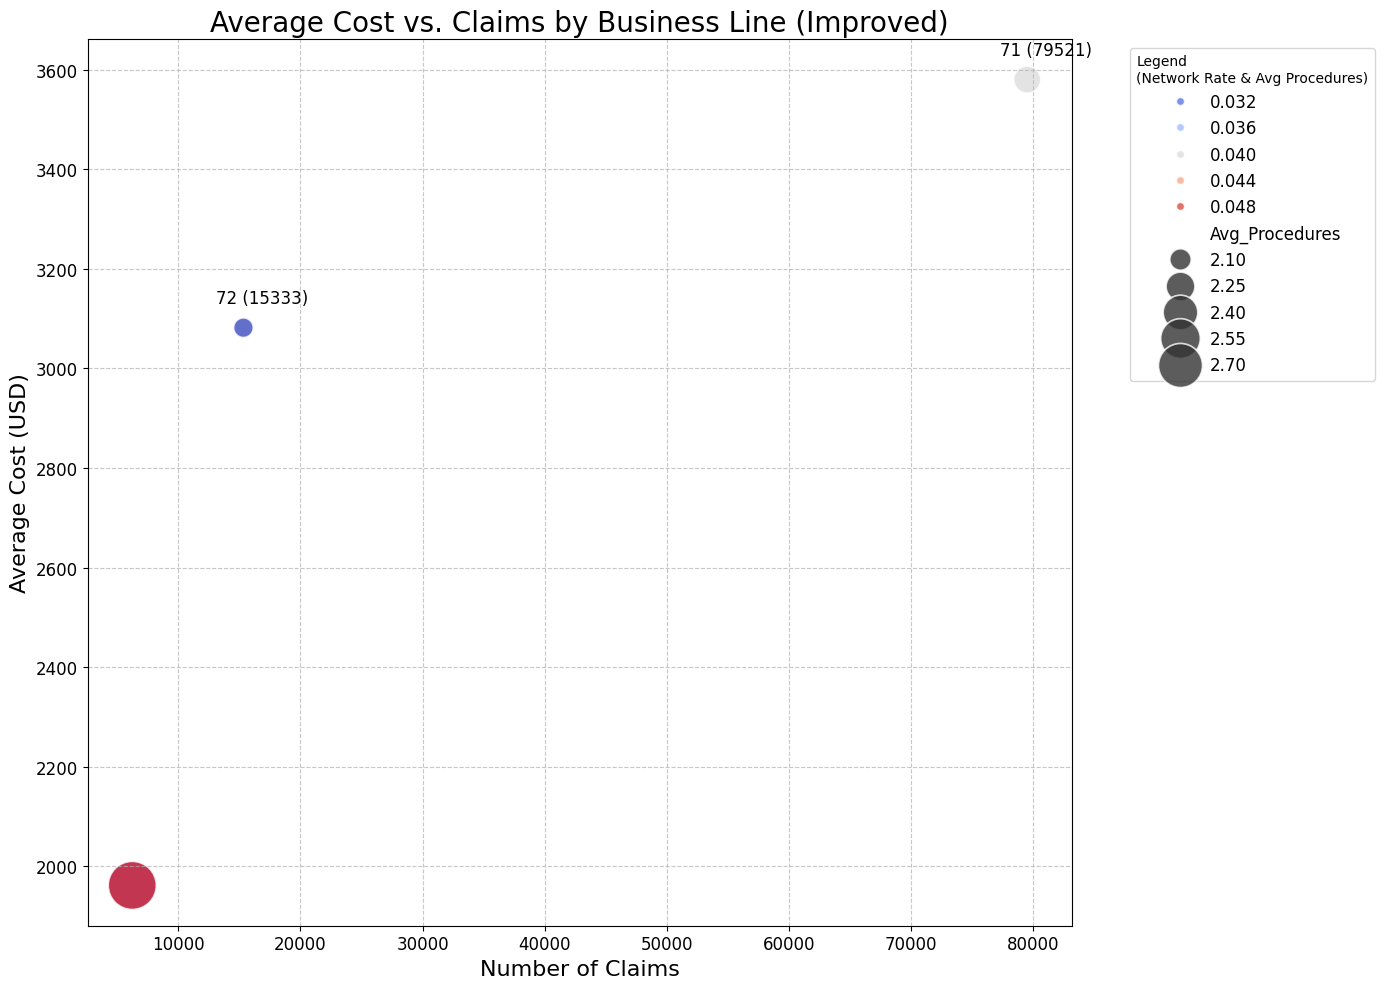

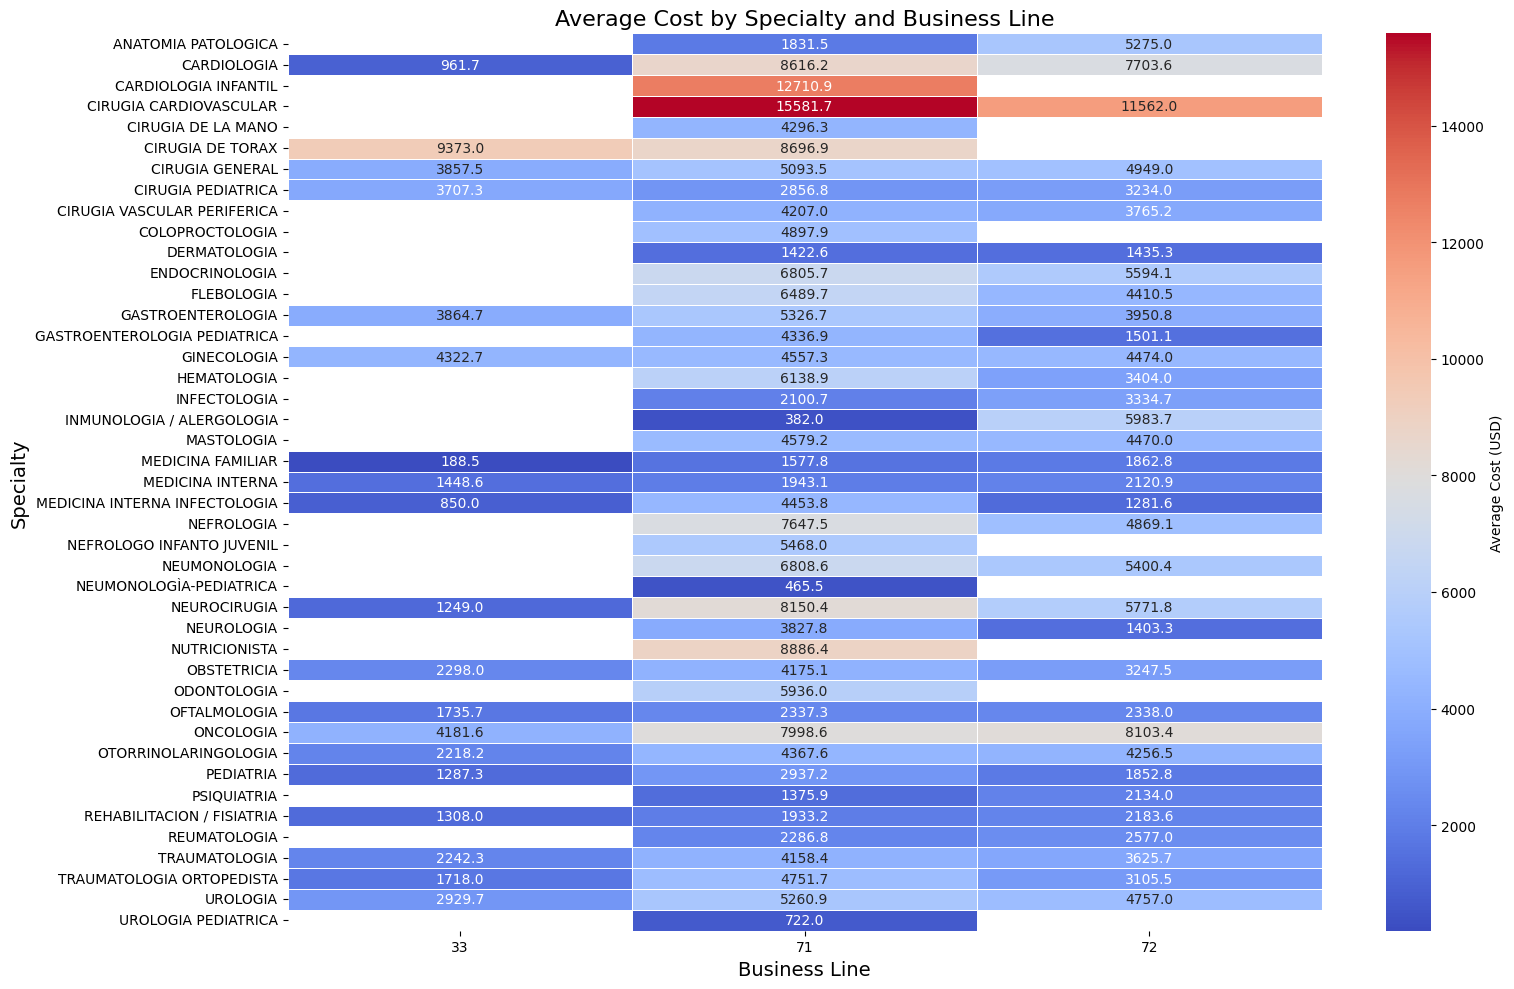

In [21]:
# Run the extended analysis and capture results
extended_results = analyze_extended_metrics()
df_extended = extended_results['df_extended']  # Ensure df_extended is available

# Visualization for Extended Analysis

# 1. Medical Specialty Analysis
# Bar Chart for Network Rate by Specialty
plt.figure(figsize=(12, 8))
network_impact = extended_results['specialty_metrics']['network_rate'].sort_values(ascending=False)

sns.barplot(
    y=network_impact.index,
    x=network_impact.values,
    palette='coolwarm'
)
plt.title('Network Rate by Specialty', fontsize=16)
plt.xlabel('Network Rate', fontsize=14)
plt.ylabel('Medical Specialty', fontsize=14)
plt.tight_layout()
plt.show()

# 2. Demographics Analysis
# Heatmap for Network Rate by Age Group and Specialty
age_specialty_data = (
    df_extended.groupby(['AGE_GROUP', 'SPECIALTY'])['IN_RED']
    .mean()
    .reset_index()
    .pivot(index='AGE_GROUP', columns='SPECIALTY', values='IN_RED')  # Corrected pivot
)
plt.figure(figsize=(18, 12))
sns.heatmap(
    age_specialty_data,
    cmap='viridis',
    annot=True,  # Display exact values
    fmt='.2f',   # Limit decimals for annotations
    linewidths=0.5,
    cbar_kws={'label': 'Network Rate'}
)
plt.title('Network Rate by Age Group and Specialty', fontsize=18)
plt.xlabel('Medical Specialty', fontsize=14)
plt.ylabel('Age Group', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate labels and align
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 3. Treatment Pattern Analysis
# Boxplot of Costs by Treatment Cluster
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='TREATMENT_CLUSTER',
    y='PAID_USD',
    data=df_extended,
    palette='Set3'
)
plt.title('Distribution of Costs by Treatment Cluster', fontsize=16)
plt.xlabel('Treatment Cluster', fontsize=14)
plt.ylabel('Paid Amount (USD)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

# 4. Business Line Analysis
# Scatter Plot: Avg Cost vs. Claims by Business Line
business_metrics = extended_results['business_metrics']
plt.figure(figsize=(14, 10))

scatter = sns.scatterplot(
    x='Claims',
    y='Avg_Cost',
    size='Avg_Procedures',
    hue='Network_Rate',
    data=business_metrics,
    sizes=(200, 1200),
    palette='coolwarm',
    alpha=0.8,
    legend='brief'
)

# Annotate key points (e.g., outliers or high-impact points)
for i in range(len(business_metrics)):
    if business_metrics['Claims'].iloc[i] > 50000 or business_metrics['Avg_Cost'].iloc[i] > 3000:
        plt.text(
            business_metrics['Claims'].iloc[i] + 1500, 
            business_metrics['Avg_Cost'].iloc[i] + 50,
            f"{business_metrics.index[i]} ({business_metrics['Claims'].iloc[i]})", 
            fontsize=12,
            ha='center'
        )
handles, labels = scatter.get_legend_handles_labels()
plt.legend(
    handles=handles[1:],
    labels=labels[1:],
    title='Legend\n(Network Rate & Avg Procedures)',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=12
)
plt.title('Average Cost vs. Claims by Business Line (Improved)', fontsize=20)
plt.xlabel('Number of Claims', fontsize=16)
plt.ylabel('Average Cost (USD)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Cross-Analysis
# Heatmap for Cross-Analysis: Specialty vs. Business Line
cross_analysis = extended_results['cross_analysis']

plt.figure(figsize=(16, 10))
sns.heatmap(
    cross_analysis,
    annot=True,
    fmt='.1f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar_kws={'label': 'Average Cost (USD)'}
)
plt.title('Average Cost by Specialty and Business Line', fontsize=16)
plt.xlabel('Business Line', fontsize=14)
plt.ylabel('Specialty', fontsize=14)
plt.tight_layout()
plt.show()